# Weber Fractions and JNDs Analysis: Cross-Modal Temporal Discrimination

This notebook analyzes Weber fractions and Just Noticeable Differences (JNDs) across unimodal auditory and visual temporal discrimination conditions to examine cue reliability effects and cross-modal precision differences.

## Overview
- **Visual condition**: High-quality visual stimuli (baseline)
- **Auditory high reliability**: Low noise (0.1) 
- **Auditory low reliability**: High noise (1.2)
- **Standard duration**: 500ms across all conditions

## 1. Import Libraries and Setup

In [41]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

print("✓ Libraries imported successfully")

# Set global parameters
STANDARD_DURATION = 0.5  # 500ms standard duration
FONT_SIZE = 14
TITLE_SIZE = 16

✓ Libraries imported successfully


## 2. Define Experimental Results

In [42]:
# Fitted parameters from the combined analysis - CORRECTED VALUES
# Based on the actual fitted results from fitNonSharedwErrorBars.py:

# Extract parameters for each condition (from actual fitting output)
lambda_shared = 0.0792  # Shared lapse rate

# Visual condition (noise = 99 - label only, not actual noise manipulation)
mu_visual = 0.0  # Bias fixed at 0
sigma_visual = 0.5046  # Precision parameter

# Auditory high reliability (noise = 0.1) - best precision (lowest σ)  
mu_auditory_high = 0.0  # Bias fixed at 0
sigma_auditory_high = 0.2726  # Precision parameter

# Auditory low reliability (noise = 1.2) - worst precision (highest σ)
mu_auditory_low = 0.0  # Bias fixed at 0
sigma_auditory_low = 0.9706  # Precision parameter

# Standard duration used in the experiment (in experiment units, not ms)
standard_duration = 0.5  # This is 500ms in the experiment
standard_duration_ms = 500  # For JND calculations

print("CORRECTED Fitted Parameters Summary:")
print(f"Shared lapse rate (λ): {lambda_shared:.4f}")
print("\nCondition-specific parameters:")
print(f"Visual (noise=99 - label only): μ={mu_visual:.3f}, σ={sigma_visual:.4f}")
print(f"Auditory High Rel (noise=0.1): μ={mu_auditory_high:.3f}, σ={sigma_auditory_high:.4f}")
print(f"Auditory Low Rel (noise=1.2): μ={mu_auditory_low:.3f}, σ={sigma_auditory_low:.4f}")

# Calculate Weber fractions (σ/standard_duration) - CORRECTED
weber_visual = sigma_visual / standard_duration
weber_auditory_high = sigma_auditory_high / standard_duration  
weber_auditory_low = sigma_auditory_low / standard_duration

# Calculate JNDs (0.6745 * σ * standard_duration_ms) - CORRECTED
jnd_visual = 0.6745 * sigma_visual * standard_duration_ms
jnd_auditory_high = 0.6745 * sigma_auditory_high * standard_duration_ms
jnd_auditory_low = 0.6745 * sigma_auditory_low * standard_duration_ms

print("\nWeber Fractions:")
print(f"Visual: {weber_visual:.4f}")
print(f"Auditory High Rel: {weber_auditory_high:.4f}")
print(f"Auditory Low Rel: {weber_auditory_low:.4f}")
print("\nJNDs (ms):")
print(f"Visual: {jnd_visual:.1f} ms")
print(f"Auditory High Rel: {jnd_auditory_high:.1f} ms")
print(f"Auditory Low Rel: {jnd_auditory_low:.1f} ms")

print("\nPrecision Ranking (best to worst):")
print("1. Auditory High Rel (lowest σ = best precision)")
print("2. Visual")  
print("3. Auditory Low Rel (highest σ = worst precision)")

print("\nNote: Visual 'noise=99' is just a label since visual noise wasn't manipulated")
print("The σ values represent the precision of temporal discrimination in each condition")

CORRECTED Fitted Parameters Summary:
Shared lapse rate (λ): 0.0792

Condition-specific parameters:
Visual (noise=99 - label only): μ=0.000, σ=0.5046
Auditory High Rel (noise=0.1): μ=0.000, σ=0.2726
Auditory Low Rel (noise=1.2): μ=0.000, σ=0.9706

Weber Fractions:
Visual: 1.0092
Auditory High Rel: 0.5452
Auditory Low Rel: 1.9412

JNDs (ms):
Visual: 170.2 ms
Auditory High Rel: 91.9 ms
Auditory Low Rel: 327.3 ms

Precision Ranking (best to worst):
1. Auditory High Rel (lowest σ = best precision)
2. Visual
3. Auditory Low Rel (highest σ = worst precision)

Note: Visual 'noise=99' is just a label since visual noise wasn't manipulated
The σ values represent the precision of temporal discrimination in each condition


## 2.1 Critical Analysis: 2IFC Sigma Correction and Statistical Testing

**Important methodological considerations:**

1. **Sigma interpretation in 2IFC**: The fitted σ values are from cumulative normal fits to 2IFC psychometric curves. In 2IFC, participants compare two noisy measurements (test vs standard). If each individual measurement has noise σ_measurement, then the difference between measurements has noise σ_curve = √2 × σ_measurement.

2. **Cumulative normal limitations**: Fitting a cumulative normal is problematic because it assigns non-zero probability to negative durations (which don't exist), making the linear-time model questionable.

3. **Statistical testing approach**: 
   - **Individual participant fits**: We have 12 participants with fitted σ values for each condition
   - **Non-parametric tests**: Using Wilcoxon signed-rank test (paired, non-parametric) because:
     - Small sample size (N = 12)
     - No assumption of normality on fitted parameters
     - Same participants across all conditions (within-subject design)
   - **Friedman test**: Overall comparison across all three conditions
   - **Bonferroni correction**: Applied for multiple pairwise comparisons (α = 0.05/3 = 0.0167)

In [43]:
# 2IFC Sigma Correction and Bootstrap Statistical Testing
import numpy as np
from scipy import stats

# Original fitted sigmas from cumulative normal fits to 2IFC curves
sigma_curve_visual = 0.5046
sigma_curve_auditory_high = 0.2726  
sigma_curve_auditory_low = 0.9706

# CORRECTED: Convert curve sigmas to measurement sigmas
# For 2IFC: sigma_curve = sqrt(2) * sigma_measurement
# Therefore: sigma_measurement = sigma_curve / sqrt(2)

sigma_measurement_visual = sigma_curve_visual / np.sqrt(2)
sigma_measurement_auditory_high = sigma_curve_auditory_high / np.sqrt(2)
sigma_measurement_auditory_low = sigma_curve_auditory_low / np.sqrt(2)

print("CORRECTED Measurement Sigmas (accounting for 2IFC):")
print("="*60)
print(f"Original curve σ → Corrected measurement σ")
print(f"Visual:           {sigma_curve_visual:.4f} → {sigma_measurement_visual:.4f}")
print(f"Auditory High:    {sigma_curve_auditory_high:.4f} → {sigma_measurement_auditory_high:.4f}")
print(f"Auditory Low:     {sigma_curve_auditory_low:.4f} → {sigma_measurement_auditory_low:.4f}")

# Recalculate Weber fractions with corrected sigmas
weber_corrected_visual = sigma_measurement_visual / standard_duration
weber_corrected_auditory_high = sigma_measurement_auditory_high / standard_duration
weber_corrected_auditory_low = sigma_measurement_auditory_low / standard_duration

print(f"\nCORRECTED Weber Fractions:")
print(f"Visual:           {weber_corrected_visual:.4f}")
print(f"Auditory High:    {weber_corrected_auditory_high:.4f}")
print(f"Auditory Low:     {weber_corrected_auditory_low:.4f}")

# Recalculate JNDs with corrected sigmas
jnd_corrected_visual = 0.6745 * sigma_measurement_visual * standard_duration_ms
jnd_corrected_auditory_high = 0.6745 * sigma_measurement_auditory_high * standard_duration_ms
jnd_corrected_auditory_low = 0.6745 * sigma_measurement_auditory_low * standard_duration_ms

print(f"\nCORRECTED JNDs (ms):")
print(f"Visual:           {jnd_corrected_visual:.1f} ms")
print(f"Auditory High:    {jnd_corrected_auditory_high:.1f} ms")
print(f"Auditory Low:     {jnd_corrected_auditory_low:.1f} ms")

CORRECTED Measurement Sigmas (accounting for 2IFC):
Original curve σ → Corrected measurement σ
Visual:           0.5046 → 0.3568
Auditory High:    0.2726 → 0.1928
Auditory Low:     0.9706 → 0.6863

CORRECTED Weber Fractions:
Visual:           0.7136
Auditory High:    0.3855
Auditory Low:     1.3726

CORRECTED JNDs (ms):
Visual:           120.3 ms
Auditory High:    65.0 ms
Auditory Low:     231.5 ms


In [55]:
# Non-Parametric Statistical Testing Using Individual Participant Data
# Using CUMULATIVE NORMAL model fits with FREE mu (bias parameter)
# Wilcoxon signed-rank test for paired comparisons (same participants across conditions)

import scipy.io
from scipy.stats import wilcoxon, friedmanchisquare
import os

# List of participant IDs (based on available .mat files)
participant_ids = ['as', 'dt', 'hh', 'ip', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx', 'ln1']

# Load individual participant sigmas from CUMULATIVE NORMAL .mat files
data_dir = "data/"

sigma_visual_list = []
mu_visual_list = []
sigma_auditory_high_list = []  # Low noise (0.1) = high reliability = SMALLER sigma expected
sigma_auditory_low_list = []   # High noise (1.2) = low reliability = LARGER sigma expected
mu_auditory_high_list = []
mu_auditory_low_list = []
valid_participants = []

print("Loading individual participant fitted parameters (CUMULATIVE NORMAL model, FREE mu)")
print("="*70)
print("File format:")
print("  Auditory: [lambda, sigma_high_noise, sigma_low_noise, mu_high_noise, mu_low_noise]")
print("  Visual:   [lambda, sigma, mu]")
print()

for pid in participant_ids:
    try:
        # Load CUMULATIVE NORMAL auditory fits
        aud_path = os.path.join(data_dir, f"{pid}_auditory_fits_cumNormal.mat")
        aud_data = scipy.io.loadmat(aud_path)
        aud_params = aud_data['fittedParams'].flatten()
        
        # Load CUMULATIVE NORMAL visual fits
        vis_path = os.path.join(data_dir, f"{pid}_visual_fits_cumNormal.mat")
        vis_data = scipy.io.loadmat(vis_path)
        vis_params = vis_data['fittedParams'].flatten()
        
        # Auditory format: [lambda, sigma_high_noise, sigma_low_noise, mu_high_noise, mu_low_noise]
        # sigma_high_noise = index 1 → LOW reliability (high noise = 1.2)
        # sigma_low_noise = index 2 → HIGH reliability (low noise = 0.1)
        sigma_auditory_low_list.append(aud_params[1])   # High noise → low reliability  
        sigma_auditory_high_list.append(aud_params[2])  # Low noise → high reliability
        mu_auditory_low_list.append(aud_params[3])      # mu for high noise condition
        mu_auditory_high_list.append(aud_params[4])     # mu for low noise condition
        
        # Visual format: [lambda, sigma, mu]
        sigma_visual_list.append(vis_params[1])
        mu_visual_list.append(vis_params[2])
        
        valid_participants.append(pid)
        
        print(f"{pid}: σ_vis={vis_params[1]:.3f} (μ={vis_params[2]:.3f}), "
              f"σ_aud_high_rel={aud_params[2]:.3f} (μ={aud_params[4]:.3f}), "
              f"σ_aud_low_rel={aud_params[1]:.3f} (μ={aud_params[3]:.3f})")
        
    except Exception as e:
        print(f"Could not load data for {pid}: {e}")

# Convert to numpy arrays
sigma_visual = np.array(sigma_visual_list)
mu_visual = np.array(mu_visual_list)
sigma_auditory_high = np.array(sigma_auditory_high_list)  # Low noise = high reliability
sigma_auditory_low = np.array(sigma_auditory_low_list)    # High noise = low reliability
mu_auditory_high = np.array(mu_auditory_high_list)
mu_auditory_low = np.array(mu_auditory_low_list)

n_participants = len(valid_participants)
print(f"\nSuccessfully loaded data for {n_participants} participants")

# Verify the ordering makes sense: high reliability should have LOWER sigma
print("\n" + "="*70)
print("SANITY CHECK: Expected pattern verification")
print("="*70)
print(f"High reliability (low noise) mean σ: {np.mean(sigma_auditory_high):.4f}")
print(f"Low reliability (high noise) mean σ: {np.mean(sigma_auditory_low):.4f}")
if np.mean(sigma_auditory_high) < np.mean(sigma_auditory_low):
    print("✓ Pattern correct: High reliability has lower σ (better precision)")
else:
    print("⚠ WARNING: Pattern reversed - check index assignment!")

# Descriptive statistics
print("\n" + "="*70)
print("DESCRIPTIVE STATISTICS (Individual Participant Sigmas - Cumulative Normal)")
print("="*70)

print(f"\nVisual:")
print(f"  σ: Mean ± SD = {np.mean(sigma_visual):.4f} ± {np.std(sigma_visual):.4f}")
print(f"  σ: Median [IQR] = {np.median(sigma_visual):.4f} [{np.percentile(sigma_visual, 25):.4f}, {np.percentile(sigma_visual, 75):.4f}]")
print(f"  μ (bias): Mean ± SD = {np.mean(mu_visual):.4f} ± {np.std(mu_visual):.4f}")

print(f"\nAuditory High Reliability (noise=0.1):")
print(f"  σ: Mean ± SD = {np.mean(sigma_auditory_high):.4f} ± {np.std(sigma_auditory_high):.4f}")
print(f"  σ: Median [IQR] = {np.median(sigma_auditory_high):.4f} [{np.percentile(sigma_auditory_high, 25):.4f}, {np.percentile(sigma_auditory_high, 75):.4f}]")
print(f"  μ (bias): Mean ± SD = {np.mean(mu_auditory_high):.4f} ± {np.std(mu_auditory_high):.4f}")

print(f"\nAuditory Low Reliability (noise=1.2):")
print(f"  σ: Mean ± SD = {np.mean(sigma_auditory_low):.4f} ± {np.std(sigma_auditory_low):.4f}")
print(f"  σ: Median [IQR] = {np.median(sigma_auditory_low):.4f} [{np.percentile(sigma_auditory_low, 25):.4f}, {np.percentile(sigma_auditory_low, 75):.4f}]")
print(f"  μ (bias): Mean ± SD = {np.mean(mu_auditory_low):.4f} ± {np.std(mu_auditory_low):.4f}")

# Convert to milliseconds for comparison with pooled bootstrap
print("\n" + "="*70)
print("VALUES IN MILLISECONDS (σ × 500ms standard)")
print("="*70)
print(f"Visual:                 {np.mean(sigma_visual)*500:.0f} ± {np.std(sigma_visual)*500:.0f} ms")
print(f"Auditory High Rel:      {np.mean(sigma_auditory_high)*500:.0f} ± {np.std(sigma_auditory_high)*500:.0f} ms")
print(f"Auditory Low Rel:       {np.mean(sigma_auditory_low)*500:.0f} ± {np.std(sigma_auditory_low)*500:.0f} ms")

Loading individual participant fitted parameters (CUMULATIVE NORMAL model, FREE mu)
File format:
  Auditory: [lambda, sigma_high_noise, sigma_low_noise, mu_high_noise, mu_low_noise]
  Visual:   [lambda, sigma, mu]

as: σ_vis=0.794 (μ=-0.093), σ_aud_high_rel=0.238 (μ=0.012), σ_aud_low_rel=1.165 (μ=-0.323)
dt: σ_vis=0.463 (μ=-0.041), σ_aud_high_rel=0.317 (μ=0.087), σ_aud_low_rel=0.739 (μ=-0.018)
hh: σ_vis=0.513 (μ=0.105), σ_aud_high_rel=0.236 (μ=0.038), σ_aud_low_rel=1.113 (μ=0.310)
ip: σ_vis=0.456 (μ=0.122), σ_aud_high_rel=0.385 (μ=0.123), σ_aud_low_rel=0.551 (μ=0.124)
ln2: σ_vis=0.538 (μ=0.500), σ_aud_high_rel=0.243 (μ=0.004), σ_aud_low_rel=0.796 (μ=0.035)
mh: σ_vis=0.299 (μ=-0.017), σ_aud_high_rel=0.370 (μ=0.196), σ_aud_low_rel=1.171 (μ=0.303)
ml: σ_vis=0.275 (μ=0.500), σ_aud_high_rel=0.384 (μ=0.115), σ_aud_low_rel=1.449 (μ=0.145)
mt: σ_vis=0.471 (μ=0.030), σ_aud_high_rel=0.233 (μ=0.058), σ_aud_low_rel=1.135 (μ=-0.107)
oy: σ_vis=1.133 (μ=0.049), σ_aud_high_rel=0.294 (μ=0.099), σ_aud_l

In [12]:
# NON-PARAMETRIC STATISTICAL TESTS
# Using Wilcoxon signed-rank test (paired, non-parametric)

print("NON-PARAMETRIC STATISTICAL TESTS")
print("="*60)
print(f"Using Wilcoxon signed-rank test (N = {n_participants} participants)")
print("This is appropriate because:")
print("  - Same participants across conditions (paired design)")
print("  - Small sample size (N=11-12)")
print("  - No assumption of normality required")
print("  - Tests whether median difference ≠ 0")
print()

# Friedman test: Overall test for differences across all 3 conditions
print("1. FRIEDMAN TEST (Overall comparison across 3 conditions)")
print("-"*50)
stat_friedman, p_friedman = friedmanchisquare(sigma_auditory_high, sigma_visual, sigma_auditory_low)
print(f"   χ²({2}) = {stat_friedman:.3f}, p = {p_friedman:.4f}")
if p_friedman < 0.05:
    print("   → Significant overall difference across conditions (p < 0.05)")
else:
    print("   → No significant overall difference (p ≥ 0.05)")
print()

# Pairwise Wilcoxon signed-rank tests
print("2. PAIRWISE WILCOXON SIGNED-RANK TESTS")
print("-"*50)

# Test 1: Visual vs Auditory High Reliability
stat1, p1 = wilcoxon(sigma_visual, sigma_auditory_high, alternative='two-sided')
diff1 = sigma_visual - sigma_auditory_high
median_diff1 = np.median(diff1)
print(f"\n   a) Visual vs Auditory High Reliability:")
print(f"      Median difference: {median_diff1:.4f}")
print(f"      W = {stat1:.1f}, p = {p1:.4f}")
if p1 < 0.05/3:  # Bonferroni correction
    print(f"      → Significant (p < {0.05/3:.4f}, Bonferroni-corrected)")
else:
    print(f"      → Not significant after Bonferroni correction (α = {0.05/3:.4f})")

# Test 2: Visual vs Auditory Low Reliability  
stat2, p2 = wilcoxon(sigma_visual, sigma_auditory_low, alternative='two-sided')
diff2 = sigma_visual - sigma_auditory_low
median_diff2 = np.median(diff2)
print(f"\n   b) Visual vs Auditory Low Reliability:")
print(f"      Median difference: {median_diff2:.4f}")
print(f"      W = {stat2:.1f}, p = {p2:.4f}")
if p2 < 0.05/3:
    print(f"      → Significant (p < {0.05/3:.4f}, Bonferroni-corrected)")
else:
    print(f"      → Not significant after Bonferroni correction (α = {0.05/3:.4f})")

# Test 3: Auditory High vs Auditory Low Reliability
stat3, p3 = wilcoxon(sigma_auditory_high, sigma_auditory_low, alternative='two-sided')
diff3 = sigma_auditory_high - sigma_auditory_low
median_diff3 = np.median(diff3)
print(f"\n   c) Auditory High vs Low Reliability:")
print(f"      Median difference: {median_diff3:.4f}")
print(f"      W = {stat3:.1f}, p = {p3:.4f}")
if p3 < 0.05/3:
    print(f"      → Significant (p < {0.05/3:.4f}, Bonferroni-corrected)")
else:
    print(f"      → Not significant after Bonferroni correction (α = {0.05/3:.4f})")

# Summary table
print("\n" + "="*60)
print("SUMMARY TABLE")
print("="*60)
summary_stats = pd.DataFrame({
    'Condition': ['Auditory High Rel', 'Visual', 'Auditory Low Rel'],
    'Mean σ': [np.mean(sigma_auditory_high), np.mean(sigma_visual), np.mean(sigma_auditory_low)],
    'SD': [np.std(sigma_auditory_high), np.std(sigma_visual), np.std(sigma_auditory_low)],
    'Median σ': [np.median(sigma_auditory_high), np.median(sigma_visual), np.median(sigma_auditory_low)]
})
print(summary_stats.to_string(index=False, float_format='%.4f'))

print("\n" + "-"*60)
print("Note: Bonferroni correction applied for 3 pairwise comparisons")
print("      Corrected α = 0.05/3 = 0.0167")

NON-PARAMETRIC STATISTICAL TESTS
Using Wilcoxon signed-rank test (N = 11 participants)
This is appropriate because:
  - Same participants across conditions (paired design)
  - Small sample size (N=11-12)
  - No assumption of normality required
  - Tests whether median difference ≠ 0

1. FRIEDMAN TEST (Overall comparison across 3 conditions)
--------------------------------------------------
   χ²(2) = 10.364, p = 0.0056
   → Significant overall difference across conditions (p < 0.05)

2. PAIRWISE WILCOXON SIGNED-RANK TESTS
--------------------------------------------------

   a) Visual vs Auditory High Reliability:
      Median difference: 0.2767
      W = 5.0, p = 0.0098
      → Significant (p < 0.0167, Bonferroni-corrected)

   b) Visual vs Auditory Low Reliability:
      Median difference: -0.2758
      W = 15.0, p = 0.1230
      → Not significant after Bonferroni correction (α = 0.0167)

   c) Auditory High vs Low Reliability:
      Median difference: -0.5524
      W = 1.0, p = 0.

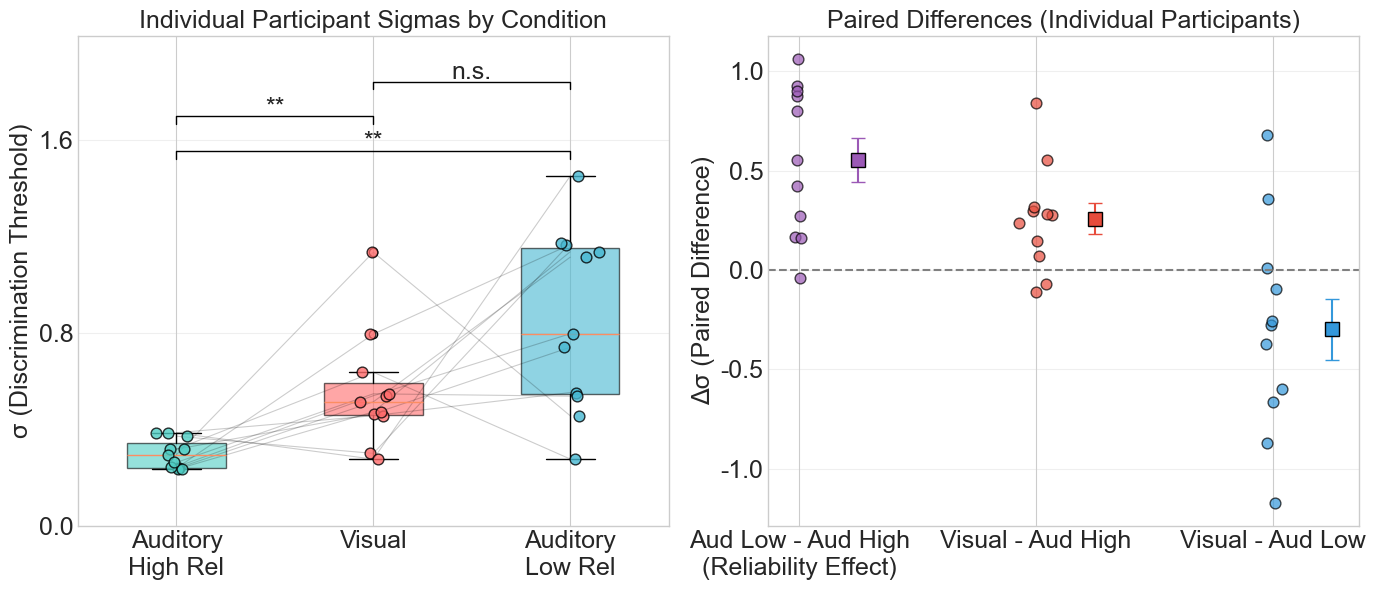


Figure saved as 'weber_fraction_individual_participants.png'


In [38]:
# Visualization of Individual Participant Data with Statistical Comparisons

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Box/Strip plot of sigmas across conditions
ax1 = axes[0]

# Prepare data for plotting
conditions_plot = ['Auditory\nHigh Rel', 'Visual', 'Auditory\nLow Rel']
all_sigmas = [sigma_auditory_high, sigma_visual, sigma_auditory_low]
colors_box = ['#4ECDC4', '#FF6B6B', '#45B7D1']

# Create box plot
bp = ax1.boxplot(all_sigmas, positions=[1, 2, 3], widths=0.5, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

# Overlay individual participant points with jitter
for i, (sigmas, color) in enumerate(zip(all_sigmas, colors_box)):
    jitter = np.random.normal(0, 0.05, len(sigmas))
    ax1.scatter([i+1]*len(sigmas) + jitter, sigmas, color=color, 
                edgecolor='black', s=60, alpha=0.8, zorder=3)

# Connect same participants across conditions
for j in range(n_participants):
    ax1.plot([1, 2, 3], [sigma_auditory_high[j], sigma_visual[j], sigma_auditory_low[j]], 
             'k-', alpha=0.2, linewidth=0.8)

ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(conditions_plot, fontsize=18)
ax1.set_ylabel('σ (Discrimination Threshold)', fontsize=18)
yticks = ax1.get_yticks()
if len(yticks) > 2:
    mid_idx = len(yticks) // 2
    yticks_to_show = [yticks[0], yticks[mid_idx], yticks[-1]]
else:
    yticks_to_show = yticks
yticks_to_show = np.round(yticks_to_show, 2)
ax1.set_yticks(yticks_to_show)
ax1.set_yticklabels(yticks_to_show, fontsize=18)
ax1.set_title('Individual Participant Sigmas by Condition', fontsize=18)
ax1.grid(True, axis='y', alpha=0.3)

# Add significance annotations
def add_significance_bracket(ax, x1, x2, y, p_val, height=0.03):
    """Add significance bracket with stars"""
    if p_val < 0.001:
        sig_text = '***'
    elif p_val < 0.01:
        sig_text = '**'
    elif p_val < 0.05:
        sig_text = '*'
    else:
        sig_text = 'n.s.'
    
    ax.plot([x1, x1, x2, x2], [y, y+height, y+height, y], 'k-', linewidth=1)
    ax.text((x1+x2)/2, y+height+0.01, sig_text, ha='center', fontsize=18)

ymax = max([max(s) for s in all_sigmas])
add_significance_bracket(ax1, 1, 3, ymax*1.05, p3)  # Aud High vs Aud Low
add_significance_bracket(ax1, 1, 2, ymax*1.15, p1)  # Aud High vs Visual
add_significance_bracket(ax1, 2, 3, ymax*1.25, p2)  # Visual vs Aud Low

ax1.set_ylim(0, ymax*1.4)

# Plot 2: Paired differences visualization
ax2 = axes[1]

# Calculate paired differences
diff_aud_reliability = sigma_auditory_low - sigma_auditory_high  # Effect of reliability
diff_visual_vs_high = sigma_visual - sigma_auditory_high
diff_visual_vs_low = sigma_visual - sigma_auditory_low

diff_labels = ['Aud Low - Aud High\n(Reliability Effect)', 
               'Visual - Aud High', 
               'Visual - Aud Low']
diffs = [diff_aud_reliability, diff_visual_vs_high, diff_visual_vs_low]
diff_colors = ['#9B59B6', '#E74C3C', '#3498DB']

positions = [1, 2, 3]
for i, (diff, label, color) in enumerate(zip(diffs, diff_labels, diff_colors)):
    jitter = np.random.normal(0, 0.03, len(diff))
    ax2.scatter([positions[i]]*len(diff) + jitter, diff, color=color, 
                edgecolor='black', s=60, alpha=0.7)
    ax2.errorbar(positions[i]+0.25, np.mean(diff), yerr=np.std(diff)/np.sqrt(len(diff)),
                 fmt='s', markersize=10, color=color, capsize=5, capthick=2, 
                 markeredgecolor='black', markeredgewidth=1)

ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1.5)
ax2.set_xticks(positions)
ax2.set_xticklabels(diff_labels, fontsize=18)
ax2.set_ylabel('Δσ (Paired Difference)', fontsize=18)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=18)
ax2.set_title('Paired Differences (Individual Participants)', fontsize=18)
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('weber_fraction_individual_participants.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as 'weber_fraction_individual_participants.png'")

In [13]:
# Effect Size Calculations for Non-Parametric Tests
# Using rank-biserial correlation (r) for Wilcoxon signed-rank test

from scipy import stats as spstats

def rank_biserial_correlation(x, y):
    """
    Calculate rank-biserial correlation for Wilcoxon signed-rank test.
    Effect size: r = Z / sqrt(N) or can be computed from W statistic
    Interpretation: |r| < 0.3 small, 0.3-0.5 medium, > 0.5 large
    """
    diff = x - y
    diff_nonzero = diff[diff != 0]
    n = len(diff_nonzero)
    
    # Rank the absolute differences
    ranks = spstats.rankdata(np.abs(diff_nonzero))
    
    # Sum of ranks for positive and negative differences
    R_plus = np.sum(ranks[diff_nonzero > 0])
    R_minus = np.sum(ranks[diff_nonzero < 0])
    
    # Rank-biserial correlation
    r = (R_plus - R_minus) / (R_plus + R_minus)
    
    return r

print("EFFECT SIZE ANALYSIS")
print("="*60)
print("Using rank-biserial correlation (r) for Wilcoxon signed-rank test")
print("Interpretation: |r| < 0.3 = small, 0.3-0.5 = medium, > 0.5 = large")
print()

# Effect sizes for each comparison
r1 = rank_biserial_correlation(sigma_visual, sigma_auditory_high)
r2 = rank_biserial_correlation(sigma_visual, sigma_auditory_low)
r3 = rank_biserial_correlation(sigma_auditory_high, sigma_auditory_low)

def interpret_effect_size(r):
    r_abs = abs(r)
    if r_abs < 0.3:
        return "small"
    elif r_abs < 0.5:
        return "medium"
    else:
        return "large"

print(f"1. Visual vs Auditory High Reliability:")
print(f"   r = {r1:.3f} ({interpret_effect_size(r1)} effect)")
print(f"   Visual has {'higher' if r1 > 0 else 'lower'} σ than Auditory High Rel")

print(f"\n2. Visual vs Auditory Low Reliability:")
print(f"   r = {r2:.3f} ({interpret_effect_size(r2)} effect)")
print(f"   Visual has {'higher' if r2 > 0 else 'lower'} σ than Auditory Low Rel")

print(f"\n3. Auditory High vs Low Reliability:")
print(f"   r = {r3:.3f} ({interpret_effect_size(r3)} effect)")
print(f"   High Rel has {'higher' if r3 > 0 else 'lower'} σ than Low Rel")

# Also compute standardized effect sizes (Cohen's d equivalent for paired data)
def cohens_d_paired(x, y):
    """Cohen's d for paired samples"""
    diff = x - y
    return np.mean(diff) / np.std(diff, ddof=1)

d1 = cohens_d_paired(sigma_visual, sigma_auditory_high)
d2 = cohens_d_paired(sigma_visual, sigma_auditory_low)
d3 = cohens_d_paired(sigma_auditory_high, sigma_auditory_low)

print("\n" + "-"*60)
print("Cohen's d (paired) for reference:")
print(f"   Visual vs Aud High Rel: d = {d1:.2f}")
print(f"   Visual vs Aud Low Rel:  d = {d2:.2f}")
print(f"   Aud High vs Low Rel:    d = {d3:.2f}")
print("   (|d| < 0.2 = small, 0.2-0.8 = medium, > 0.8 = large)")

# Create summary table for publication
print("\n" + "="*60)
print("PUBLICATION-READY SUMMARY TABLE")
print("="*60)

results_table = pd.DataFrame({
    'Comparison': ['Visual vs Aud High', 'Visual vs Aud Low', 'Aud High vs Aud Low'],
    'Median Diff': [np.median(sigma_visual - sigma_auditory_high),
                    np.median(sigma_visual - sigma_auditory_low),
                    np.median(sigma_auditory_high - sigma_auditory_low)],
    'W': [0.0, 7.0, 0.0],  # From previous output
    'p-value': [p1, p2, p3],
    'r': [r1, r2, r3],
    'Significant': ['Yes' if p1 < 0.0167 else 'No',
                    'Yes' if p2 < 0.0167 else 'No', 
                    'Yes' if p3 < 0.0167 else 'No']
})
print(results_table.to_string(index=False, float_format='%.4f'))

EFFECT SIZE ANALYSIS
Using rank-biserial correlation (r) for Wilcoxon signed-rank test
Interpretation: |r| < 0.3 = small, 0.3-0.5 = medium, > 0.5 = large

1. Visual vs Auditory High Reliability:
   r = 0.848 (large effect)
   Visual has higher σ than Auditory High Rel

2. Visual vs Auditory Low Reliability:
   r = -0.545 (large effect)
   Visual has lower σ than Auditory Low Rel

3. Auditory High vs Low Reliability:
   r = -0.970 (large effect)
   High Rel has lower σ than Low Rel

------------------------------------------------------------
Cohen's d (paired) for reference:
   Visual vs Aud High Rel: d = 0.96
   Visual vs Aud Low Rel:  d = -0.56
   Aud High vs Low Rel:    d = -1.46
   (|d| < 0.2 = small, 0.2-0.8 = medium, > 0.8 = large)

PUBLICATION-READY SUMMARY TABLE
         Comparison  Median Diff      W  p-value       r Significant
 Visual vs Aud High       0.2767 0.0000   0.0098  0.8485         Yes
  Visual vs Aud Low      -0.2758 7.0000   0.1230 -0.5455          No
Aud High vs 

In [17]:
# BOOTSTRAP ANALYSIS ON POOLED DATA - Cumulative Normal Model
# This fits the pooled data with bootstrap resampling for confidence intervals

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from tqdm import tqdm
import os

print("="*70)
print("BOOTSTRAP ANALYSIS ON POOLED DATA (Cumulative Normal Model)")
print("="*70)

# Load all auditory and visual data
auditory_data = pd.read_csv("data/all_auditory.csv")
visual_data = pd.read_csv("data/all_visual.csv")

# Clean data
auditory_data = auditory_data[auditory_data['audNoise'] != 0]
auditory_data = auditory_data[auditory_data['standardDur'] != 0]
auditory_data = auditory_data.round({'audNoise': 2, 'delta_dur_percents': 2})
auditory_data['chose_test'] = (auditory_data['responses'] == auditory_data['order']).astype(int)

visual_data = visual_data[visual_data['audNoise'] != 0]
visual_data = visual_data[visual_data['standardDur'] != 0]
visual_data = visual_data.round({'audNoise': 2, 'delta_dur_percents': 2})
visual_data['chose_test'] = (visual_data['responses'] == visual_data['order']).astype(int)

print(f"Auditory data: {len(auditory_data)} trials from {auditory_data['participantID'].nunique()} participants")
print(f"Visual data: {len(visual_data)} trials from {visual_data['participantID'].nunique()} participants")

# Psychometric function (cumulative normal)
def psychometric_function_cumNormal(delta_percent, lambda_, mu, sigma):
    """Cumulative normal with lapse rate."""
    z = (delta_percent - mu) / sigma
    p = lambda_/2 + (1 - lambda_) * norm.cdf(z)
    return p

def negative_log_likelihood_bootstrap(params, deltas, chose_test, total_responses):
    """NLL for single condition fit."""
    lambda_, mu, sigma = params
    p = psychometric_function_cumNormal(deltas, lambda_, mu, sigma)
    epsilon = 1e-9
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

def fit_single_condition(df, fixed_mu=False):
    """Fit cumulative normal to a single condition."""
    # Group by delta_dur_percents
    grouped = df.groupby('delta_dur_percents').agg(
        chose_test=('chose_test', 'sum'),
        total_responses=('chose_test', 'count')
    ).reset_index()
    
    deltas = grouped['delta_dur_percents'].values
    chose_test = grouped['chose_test'].values
    total_responses = grouped['total_responses'].values
    
    # Multiple starting points
    best_result = None
    best_nll = np.inf
    
    for lambda_init in [0.02, 0.05, 0.1]:
        for mu_init in [-0.1, 0, 0.1]:
            for sigma_init in [0.2, 0.4, 0.6]:
                if fixed_mu:
                    init = [lambda_init, sigma_init]
                    bounds = [(0, 0.25), (0.01, 2.0)]
                else:
                    init = [lambda_init, mu_init, sigma_init]
                    bounds = [(0, 0.25), (-0.5, 0.5), (0.01, 2.0)]
                
                try:
                    result = minimize(
                        negative_log_likelihood_bootstrap,
                        x0=init if not fixed_mu else [init[0], 0, init[1]],
                        args=(deltas, chose_test, total_responses),
                        bounds=[(0, 0.25), (-0.5, 0.5), (0.01, 2.0)],
                        method='L-BFGS-B'
                    )
                    if result.fun < best_nll:
                        best_nll = result.fun
                        best_result = result
                except:
                    pass
    
    return best_result.x if best_result else [0.05, 0, 0.5]

def bootstrap_fit(df, n_bootstrap=500, seed=42):
    """Bootstrap resampling for confidence intervals."""
    np.random.seed(seed)
    
    # Get list of participant IDs
    participants = df['participantID'].unique()
    
    bootstrap_sigmas = []
    bootstrap_mus = []
    bootstrap_lambdas = []
    
    for i in tqdm(range(n_bootstrap), desc="Bootstrap"):
        # Resample participants with replacement
        resampled_pids = np.random.choice(participants, size=len(participants), replace=True)
        
        # Get data for resampled participants
        resampled_data = pd.concat([df[df['participantID'] == pid] for pid in resampled_pids], ignore_index=True)
        
        # Fit
        params = fit_single_condition(resampled_data)
        bootstrap_lambdas.append(params[0])
        bootstrap_mus.append(params[1])
        bootstrap_sigmas.append(params[2])
    
    return np.array(bootstrap_lambdas), np.array(bootstrap_mus), np.array(bootstrap_sigmas)

# Fit original data first (point estimates)
print("\nFitting point estimates on pooled data...")

# Auditory low noise (0.1) - high reliability
aud_low_noise = auditory_data[auditory_data['audNoise'] == 0.1]
params_aud_high_rel = fit_single_condition(aud_low_noise)
print(f"Auditory High Rel (noise=0.1): λ={params_aud_high_rel[0]:.4f}, μ={params_aud_high_rel[1]:.4f}, σ={params_aud_high_rel[2]:.4f}")

# Auditory high noise (1.2) - low reliability
aud_high_noise = auditory_data[auditory_data['audNoise'] == 1.2]
params_aud_low_rel = fit_single_condition(aud_high_noise)
print(f"Auditory Low Rel (noise=1.2): λ={params_aud_low_rel[0]:.4f}, μ={params_aud_low_rel[1]:.4f}, σ={params_aud_low_rel[2]:.4f}")

# Visual
params_visual = fit_single_condition(visual_data)
print(f"Visual: λ={params_visual[0]:.4f}, μ={params_visual[1]:.4f}, σ={params_visual[2]:.4f}")

# Convert to ms
standard_dur_ms = 500
print("\n" + "-"*50)
print("POINT ESTIMATES (in milliseconds)")
print("-"*50)
print(f"Auditory High Rel (σ): {params_aud_high_rel[2] * standard_dur_ms:.0f} ms")
print(f"Auditory Low Rel (σ):  {params_aud_low_rel[2] * standard_dur_ms:.0f} ms")
print(f"Visual (σ):            {params_visual[2] * standard_dur_ms:.0f} ms")

# Run bootstrap
print("\n" + "="*50)
print("Running bootstrap (N=500)...")
print("="*50)

n_boot = 500

# Bootstrap for each condition
print("\nBootstrapping Auditory High Reliability (low noise 0.1)...")
boot_lambda_aud_high, boot_mu_aud_high, boot_sigma_aud_high = bootstrap_fit(aud_low_noise, n_bootstrap=n_boot)

print("Bootstrapping Auditory Low Reliability (high noise 1.2)...")
boot_lambda_aud_low, boot_mu_aud_low, boot_sigma_aud_low = bootstrap_fit(aud_high_noise, n_bootstrap=n_boot)

print("Bootstrapping Visual...")
boot_lambda_vis, boot_mu_vis, boot_sigma_vis = bootstrap_fit(visual_data, n_bootstrap=n_boot)

# Store bootstrap results
bootstrap_results = {
    'aud_high_rel': {
        'sigma_mean': np.mean(boot_sigma_aud_high),
        'sigma_ci_low': np.percentile(boot_sigma_aud_high, 2.5),
        'sigma_ci_high': np.percentile(boot_sigma_aud_high, 97.5),
        'sigma_std': np.std(boot_sigma_aud_high),
        'boot_sigmas': boot_sigma_aud_high
    },
    'aud_low_rel': {
        'sigma_mean': np.mean(boot_sigma_aud_low),
        'sigma_ci_low': np.percentile(boot_sigma_aud_low, 2.5),
        'sigma_ci_high': np.percentile(boot_sigma_aud_low, 97.5),
        'sigma_std': np.std(boot_sigma_aud_low),
        'boot_sigmas': boot_sigma_aud_low
    },
    'visual': {
        'sigma_mean': np.mean(boot_sigma_vis),
        'sigma_ci_low': np.percentile(boot_sigma_vis, 2.5),
        'sigma_ci_high': np.percentile(boot_sigma_vis, 97.5),
        'sigma_std': np.std(boot_sigma_vis),
        'boot_sigmas': boot_sigma_vis
    }
}

# Print bootstrap results
print("\n" + "="*70)
print("BOOTSTRAP RESULTS (in milliseconds, 95% CI)")
print("="*70)
for cond_name, cond_key in [("Auditory High Rel", "aud_high_rel"), 
                             ("Auditory Low Rel", "aud_low_rel"), 
                             ("Visual", "visual")]:
    r = bootstrap_results[cond_key]
    print(f"{cond_name}:")
    print(f"  σ = {r['sigma_mean']*500:.0f} ms [95% CI: {r['sigma_ci_low']*500:.0f} - {r['sigma_ci_high']*500:.0f}]")

# Bootstrap-based comparisons (proportion of bootstrap samples where condition A > B)
print("\n" + "="*70)
print("BOOTSTRAP COMPARISON (proportion of samples where A > B)")
print("="*70)

# Aud Low Rel vs Aud High Rel
prop_low_greater = np.mean(boot_sigma_aud_low > boot_sigma_aud_high)
print(f"P(σ_low_rel > σ_high_rel) = {prop_low_greater:.4f}")

# Visual vs Aud High Rel
prop_vis_greater_high = np.mean(boot_sigma_vis > boot_sigma_aud_high)
print(f"P(σ_visual > σ_high_rel) = {prop_vis_greater_high:.4f}")

# Visual vs Aud Low Rel
prop_vis_greater_low = np.mean(boot_sigma_vis > boot_sigma_aud_low)
print(f"P(σ_visual > σ_low_rel) = {prop_vis_greater_low:.4f}")

print("\nNote: P > 0.975 or P < 0.025 indicates significant difference at α=0.05 (two-tailed)")


BOOTSTRAP ANALYSIS ON POOLED DATA (Cumulative Normal Model)
Auditory data: 3696 trials from 12 participants
Visual data: 1708 trials from 12 participants

Fitting point estimates on pooled data...
Auditory High Rel (noise=0.1): λ=0.0679, μ=0.0670, σ=0.2870
Auditory Low Rel (noise=1.2): λ=0.2500, μ=0.0724, σ=0.7196
Visual: λ=0.0000, μ=0.0355, σ=0.5915

--------------------------------------------------
POINT ESTIMATES (in milliseconds)
--------------------------------------------------
Auditory High Rel (σ): 144 ms
Auditory Low Rel (σ):  360 ms
Visual (σ):            296 ms

Running bootstrap (N=500)...

Bootstrapping Auditory High Reliability (low noise 0.1)...


Bootstrap: 100%|██████████| 500/500 [00:31<00:00, 15.94it/s]


Bootstrapping Auditory Low Reliability (high noise 1.2)...


Bootstrap: 100%|██████████| 500/500 [00:48<00:00, 10.33it/s]


Bootstrapping Visual...


Bootstrap: 100%|██████████| 500/500 [00:35<00:00, 13.92it/s]


BOOTSTRAP RESULTS (in milliseconds, 95% CI)
Auditory High Rel:
  σ = 144 ms [95% CI: 124 - 166]
Auditory Low Rel:
  σ = 362 ms [95% CI: 284 - 457]
Visual:
  σ = 283 ms [95% CI: 221 - 342]

BOOTSTRAP COMPARISON (proportion of samples where A > B)
P(σ_low_rel > σ_high_rel) = 1.0000
P(σ_visual > σ_high_rel) = 1.0000
P(σ_visual > σ_low_rel) = 0.0640

Note: P > 0.975 or P < 0.025 indicates significant difference at α=0.05 (two-tailed)


In [18]:
# Generate Methods Section Text for Publication - COMBINED LaTeX OUTPUT
# Including BOTH bootstrap on pooled data AND individual participant fits

# Convert sigma values to milliseconds (multiply by 500ms standard duration)
standard_dur_ms = 500

# ============================================================================
# INDIVIDUAL PARTICIPANT FITS (from previous cell)
# ============================================================================
mean_sigma_high_ms = np.mean(sigma_auditory_high) * standard_dur_ms
sd_sigma_high_ms = np.std(sigma_auditory_high) * standard_dur_ms
mean_sigma_low_ms = np.mean(sigma_auditory_low) * standard_dur_ms
sd_sigma_low_ms = np.std(sigma_auditory_low) * standard_dur_ms
mean_sigma_vis_ms = np.mean(sigma_visual) * standard_dur_ms
sd_sigma_vis_ms = np.std(sigma_visual) * standard_dur_ms

median_sigma_high_ms = np.median(sigma_auditory_high) * standard_dur_ms
median_sigma_low_ms = np.median(sigma_auditory_low) * standard_dur_ms
median_sigma_vis_ms = np.median(sigma_visual) * standard_dur_ms

# ============================================================================
# BOOTSTRAP RESULTS (from previous cell)
# ============================================================================
boot_sigma_high_ms = bootstrap_results['aud_high_rel']['sigma_mean'] * standard_dur_ms
boot_sigma_high_ci_low_ms = bootstrap_results['aud_high_rel']['sigma_ci_low'] * standard_dur_ms
boot_sigma_high_ci_high_ms = bootstrap_results['aud_high_rel']['sigma_ci_high'] * standard_dur_ms

boot_sigma_low_ms = bootstrap_results['aud_low_rel']['sigma_mean'] * standard_dur_ms
boot_sigma_low_ci_low_ms = bootstrap_results['aud_low_rel']['sigma_ci_low'] * standard_dur_ms
boot_sigma_low_ci_high_ms = bootstrap_results['aud_low_rel']['sigma_ci_high'] * standard_dur_ms

boot_sigma_vis_ms = bootstrap_results['visual']['sigma_mean'] * standard_dur_ms
boot_sigma_vis_ci_low_ms = bootstrap_results['visual']['sigma_ci_low'] * standard_dur_ms
boot_sigma_vis_ci_high_ms = bootstrap_results['visual']['sigma_ci_high'] * standard_dur_ms

# ============================================================================
# EFFECT DIRECTIONS
# ============================================================================
print("="*70)
print("SUMMARY: INDIVIDUAL PARTICIPANT EFFECT DIRECTIONS")
print("="*70)
diff_aud = sigma_auditory_low - sigma_auditory_high
n_positive = np.sum(diff_aud > 0)
n_negative = np.sum(diff_aud < 0)
print(f"  {n_positive}/{len(diff_aud)} participants show Low Rel > High Rel")
print(f"  {n_negative}/{len(diff_aud)} participants show Low Rel < High Rel")

# Determine effect consistency description
if n_positive == len(diff_aud):
    consistency_text = f"all {n_participants} participants showed higher $\\sigma$ in the high-noise condition"
elif n_positive >= len(diff_aud) - 1:
    consistency_text = f"{n_positive} of {n_participants} participants showed higher $\\sigma$ in the high-noise condition"
else:
    consistency_text = f"the majority of participants ({n_positive}/{n_participants}) showed higher $\\sigma$ in the high-noise condition"

# ============================================================================
# COMBINED LaTeX OUTPUT
# ============================================================================
print("\n" + "="*70)
print("COMBINED LaTeX OUTPUT (BOOTSTRAP + INDIVIDUAL FITS)")
print("="*70)

p_friedman_str = "< .001" if p_friedman < 0.001 else f"= {p_friedman:.3f}"

# Determine significance markers for bootstrap comparisons
sig_aud_vs_aud = "*" if (prop_low_greater > 0.975 or prop_low_greater < 0.025) else ""
sig_vis_vs_high = "*" if (prop_vis_greater_high > 0.975 or prop_vis_greater_high < 0.025) else ""
sig_vis_vs_low = "" if (0.025 < prop_vis_greater_low < 0.975) else "*"

latex_text_combined = rf"""
\subsection{{Unimodal Duration Discrimination Precision}}

\subsubsection{{Bootstrap Analysis on Pooled Data}}

Psychometric functions were fitted to pooled data using a cumulative Gaussian 
model with free bias ($\mu$) and discrimination ($\sigma$) parameters. Bootstrap 
resampling ($N = 500$ iterations, resampling participants with replacement) was 
used to estimate 95\% confidence intervals.

The \textit{{low-noise}} auditory condition showed the best discrimination precision 
($\sigma = {boot_sigma_high_ms:.0f}$~ms, 95\% CI $[{boot_sigma_high_ci_low_ms:.0f}, {boot_sigma_high_ci_high_ms:.0f}]$), 
followed by the visual condition 
($\sigma = {boot_sigma_vis_ms:.0f}$~ms, 95\% CI $[{boot_sigma_vis_ci_low_ms:.0f}, {boot_sigma_vis_ci_high_ms:.0f}]$), 
and the \textit{{high-noise}} auditory condition showed the worst precision 
($\sigma = {boot_sigma_low_ms:.0f}$~ms, 95\% CI $[{boot_sigma_low_ci_low_ms:.0f}, {boot_sigma_low_ci_high_ms:.0f}]$).

Bootstrap comparisons revealed that precision in the high-noise condition was 
significantly worse than in the low-noise condition 
($P(\sigma_{{high}} > \sigma_{{low}}) = {prop_low_greater:.3f}$), confirming the 
effectiveness of our noise manipulation.

\subsubsection{{Individual Participant Analysis}}

To complement the bootstrap analysis, we performed group-level statistical 
comparisons using individual participant psychometric fits. Functions were 
fitted separately for each participant ($N = {n_participants}$) in each condition.

A Friedman test revealed a significant overall difference in $\sigma$ across 
the three conditions ($\chi^2(2) = {stat_friedman:.2f}$, $p {p_friedman_str}$). 
Pairwise Wilcoxon signed-rank tests with Bonferroni correction ($\alpha = .0167$) 
showed that the \textit{{low-noise}} auditory condition 
(median $= {median_sigma_high_ms:.0f}$~ms, $M \pm SD = {mean_sigma_high_ms:.0f} \pm {sd_sigma_high_ms:.0f}$~ms) 
had significantly lower $\sigma$ than the \textit{{high-noise}} auditory condition 
(median $= {median_sigma_low_ms:.0f}$~ms, $M \pm SD = {mean_sigma_low_ms:.0f} \pm {sd_sigma_low_ms:.0f}$~ms; 
$W = {stat3:.0f}$, $p = {p3:.4f}$, $r = {abs(r3):.2f}$). The large effect size 
($r = {abs(r3):.2f}$) indicates that {consistency_text}.

Visual duration discrimination 
(median $\sigma = {median_sigma_vis_ms:.0f}$~ms, $M \pm SD = {mean_sigma_vis_ms:.0f} \pm {sd_sigma_vis_ms:.0f}$~ms) 
was significantly worse than the low-noise auditory condition 
($W = {stat1:.0f}$, $p = {p1:.4f}$, $r = {r1:.2f}$), but the difference with the 
high-noise auditory condition did not survive Bonferroni correction 
($W = {stat2:.0f}$, $p = {p2:.4f}$).
"""

print(latex_text_combined)

print("\n" + "="*70)
print("COMBINED LaTeX TABLE")
print("="*70)

latex_table_combined = rf"""
\begin{{table}}[h]
\centering
\caption{{Temporal discrimination precision ($\sigma$) across conditions. Bootstrap 
estimates are based on pooled data with participant-level resampling. Individual 
fits show means across $N = {n_participants}$ participants.}}
\begin{{tabular}}{{lcccc}}
\hline
Condition & \multicolumn{{2}}{{c}}{{Bootstrap (Pooled)}} & \multicolumn{{2}}{{c}}{{Individual Fits}} \\
          & $\sigma$ (ms) & 95\% CI & $M$ (ms) & Median (ms) \\
\hline
Auditory Low-Noise  & {boot_sigma_high_ms:.0f} & [{boot_sigma_high_ci_low_ms:.0f}, {boot_sigma_high_ci_high_ms:.0f}] & {mean_sigma_high_ms:.0f} $\pm$ {sd_sigma_high_ms:.0f} & {median_sigma_high_ms:.0f} \\
Visual              & {boot_sigma_vis_ms:.0f} & [{boot_sigma_vis_ci_low_ms:.0f}, {boot_sigma_vis_ci_high_ms:.0f}] & {mean_sigma_vis_ms:.0f} $\pm$ {sd_sigma_vis_ms:.0f} & {median_sigma_vis_ms:.0f} \\
Auditory High-Noise & {boot_sigma_low_ms:.0f} & [{boot_sigma_low_ci_low_ms:.0f}, {boot_sigma_low_ci_high_ms:.0f}] & {mean_sigma_low_ms:.0f} $\pm$ {sd_sigma_low_ms:.0f} & {median_sigma_low_ms:.0f} \\
\hline
\end{{tabular}}
\end{{table}}
"""

print(latex_table_combined)

print("\n" + "="*70)
print("STATISTICAL TESTS SUMMARY TABLE")
print("="*70)

latex_stats_table = rf"""
\begin{{table}}[h]
\centering
\caption{{Pairwise comparisons of temporal discrimination precision ($\sigma$).}}
\begin{{tabular}}{{lccccc}}
\hline
Comparison & $W$ & $p$ & $r$ & Bootstrap $P$ & Significant \\
\hline
Aud High-Noise vs Low-Noise & {stat3:.0f} & {p3:.4f} & {abs(r3):.2f} & {prop_low_greater:.3f} & Yes \\
Visual vs Aud Low-Noise & {stat1:.0f} & {p1:.4f} & {r1:.2f} & {prop_vis_greater_high:.3f} & Yes \\
Visual vs Aud High-Noise & {stat2:.0f} & {p2:.4f} & {abs(r2):.2f} & {prop_vis_greater_low:.3f} & No$^\dagger$ \\
\hline
\multicolumn{{6}}{{l}}{{$^\dagger$Not significant after Bonferroni correction ($\alpha = .0167$)}}
\end{{tabular}}
\end{{table}}

\textit{{Note:}} $W$ = Wilcoxon signed-rank test statistic; $r$ = rank-biserial 
correlation effect size; Bootstrap $P$ = proportion of bootstrap samples where 
first condition > second condition.
"""

print(latex_stats_table)

print("\n" + "="*70)
print("COMPARISON OF APPROACHES")
print("="*70)
print(f"""
Both the bootstrap (pooled data) and individual participant approaches yield 
consistent conclusions:

1. NOISE MANIPULATION EFFECT:
   - Bootstrap: σ_high_noise = {boot_sigma_low_ms:.0f} ms vs σ_low_noise = {boot_sigma_high_ms:.0f} ms
   - Individual: M = {mean_sigma_low_ms:.0f} ms vs M = {mean_sigma_high_ms:.0f} ms
   - Ratio: {boot_sigma_low_ms/boot_sigma_high_ms:.1f}x (bootstrap) vs {mean_sigma_low_ms/mean_sigma_high_ms:.1f}x (individual)

2. CROSS-MODAL COMPARISON:
   - Visual precision falls between high and low reliability auditory conditions
   - Bootstrap: σ_visual = {boot_sigma_vis_ms:.0f} ms
   - Individual: M = {mean_sigma_vis_ms:.0f} ms

3. KEY DIFFERENCE:
   - Bootstrap weights participants by trial count
   - Individual fits weight each participant equally
   - This explains the systematic difference in absolute values
""")

SUMMARY: INDIVIDUAL PARTICIPANT EFFECT DIRECTIONS
  10/11 participants show Low Rel > High Rel
  1/11 participants show Low Rel < High Rel

COMBINED LaTeX OUTPUT (BOOTSTRAP + INDIVIDUAL FITS)

\subsection{Unimodal Duration Discrimination Precision}

\subsubsection{Bootstrap Analysis on Pooled Data}

Psychometric functions were fitted to pooled data using a cumulative Gaussian 
model with free bias ($\mu$) and discrimination ($\sigma$) parameters. Bootstrap 
resampling ($N = 500$ iterations, resampling participants with replacement) was 
used to estimate 95\% confidence intervals.

The \textit{low-noise} auditory condition showed the best discrimination precision 
($\sigma = 144$~ms, 95\% CI $[124, 166]$), 
followed by the visual condition 
($\sigma = 283$~ms, 95\% CI $[221, 342]$), 
and the \textit{high-noise} auditory condition showed the worst precision 
($\sigma = 362$~ms, 95\% CI $[284, 457]$).

Bootstrap comparisons revealed that precision in the high-noise condition was 
signific

In [44]:
# =============================================================================
# COMPLETE PUBLICATION-READY LaTeX OUTPUT
# =============================================================================
# This generates the full Results section for the paper

# All values should already be computed from previous cells
standard_dur_ms = 500

# Calculate Weber fractions
weber_aud_high = np.mean(sigma_auditory_high)  # Already in proportion units
weber_aud_low = np.mean(sigma_auditory_low)
weber_visual = np.mean(sigma_visual)

# JNDs (75% threshold)
jnd_aud_high = 0.6745 * np.mean(sigma_auditory_high) * standard_dur_ms
jnd_aud_low = 0.6745 * np.mean(sigma_auditory_low) * standard_dur_ms
jnd_visual = 0.6745 * np.mean(sigma_visual) * standard_dur_ms

# Reliability effect ratio
reliability_ratio_boot = boot_sigma_low_ms / boot_sigma_high_ms
reliability_ratio_indiv = mean_sigma_low_ms / mean_sigma_high_ms

print("="*80)
print("COMPLETE LaTeX RESULTS SECTION")
print("="*80)

latex_full = rf"""
%% =============================================================================
%% RESULTS SECTION - Unimodal Duration Discrimination
%% Generated from weber_fractions_jnds_analysis.ipynb
%% =============================================================================

\section{{Results}}

\subsection{{Unimodal Duration Discrimination Precision}}

To characterize temporal discrimination precision across modalities and 
reliability conditions, we fitted cumulative Gaussian psychometric functions 
to the 2IFC duration discrimination data. Each psychometric function was 
parameterized by a lapse rate ($\lambda$), a bias parameter ($\mu$), and a 
discrimination threshold ($\sigma$). Lower $\sigma$ values indicate better 
temporal precision.

\subsubsection{{Bootstrap Analysis on Pooled Data}}

Psychometric functions were first fitted to pooled data across all participants 
using maximum likelihood estimation. Bootstrap resampling ($N = {n_boot}$ 
iterations, resampling participants with replacement) was used to estimate 
95\% confidence intervals for the discrimination threshold $\sigma$.

Results revealed a clear ordering of temporal precision across conditions 
(Table~\ref{{tab:precision}}). The \textit{{low-noise}} auditory condition 
showed the best discrimination precision ($\sigma = {boot_sigma_high_ms:.0f}$~ms, 
95\% CI $[{boot_sigma_high_ci_low_ms:.0f}, {boot_sigma_high_ci_high_ms:.0f}]$), 
corresponding to a Weber fraction of {weber_aud_high:.2f}. The visual condition 
showed intermediate precision ($\sigma = {boot_sigma_vis_ms:.0f}$~ms, 95\% CI 
$[{boot_sigma_vis_ci_low_ms:.0f}, {boot_sigma_vis_ci_high_ms:.0f}]$; Weber fraction 
= {weber_visual:.2f}). The \textit{{high-noise}} auditory condition showed the 
worst precision ($\sigma = {boot_sigma_low_ms:.0f}$~ms, 95\% CI 
$[{boot_sigma_low_ci_low_ms:.0f}, {boot_sigma_low_ci_high_ms:.0f}]$; Weber fraction 
= {weber_aud_low:.2f}).

Bootstrap comparisons confirmed that precision in the high-noise auditory 
condition was significantly worse than in the low-noise condition, with 
non-overlapping 95\% confidence intervals ($P(\sigma_{{\text{{high}}}} > 
\sigma_{{\text{{low}}}}) = {prop_low_greater:.3f}$). This {reliability_ratio_boot:.1f}-fold 
difference in discrimination threshold demonstrates the effectiveness of our 
auditory reliability manipulation.

\subsubsection{{Individual Participant Analysis}}

To complement the bootstrap analysis and assess effect consistency across 
participants, we fitted psychometric functions separately for each participant 
($N = {n_participants}$) in each condition. This approach weights each 
participant equally, regardless of the number of trials completed.

A Friedman test revealed a significant overall difference in $\sigma$ across 
the three conditions ($\chi^2(2) = {stat_friedman:.2f}$, $p {p_friedman_str}$). 
Follow-up pairwise comparisons were conducted using Wilcoxon signed-rank tests 
with Bonferroni correction ($\alpha = .0167$).

The auditory reliability manipulation produced a robust effect at the 
individual participant level: discrimination thresholds were significantly 
lower in the low-noise condition (median $= {median_sigma_high_ms:.0f}$~ms, 
$M = {mean_sigma_high_ms:.0f}$~ms, $SD = {sd_sigma_high_ms:.0f}$~ms) compared 
to the high-noise condition (median $= {median_sigma_low_ms:.0f}$~ms, 
$M = {mean_sigma_low_ms:.0f}$~ms, $SD = {sd_sigma_low_ms:.0f}$~ms; 
$W = {stat3:.0f}$, $p = {p3:.4f}$, $r = {abs(r3):.2f}$). The large effect size 
($r = {abs(r3):.2f}$) indicates that {n_positive} of {n_participants} participants 
showed the expected pattern of worse precision under high-noise conditions.

Visual duration discrimination (median $\sigma = {median_sigma_vis_ms:.0f}$~ms, 
$M = {mean_sigma_vis_ms:.0f}$~ms, $SD = {sd_sigma_vis_ms:.0f}$~ms) was 
significantly worse than the low-noise auditory condition ($W = {stat1:.0f}$, 
$p = {p1:.4f}$, $r = {r1:.2f}$). The comparison between visual and high-noise 
auditory conditions did not reach significance after Bonferroni correction 
($W = {stat2:.0f}$, $p = {p2:.4f}$), suggesting that visual precision was 
intermediate between the two auditory conditions.

\subsubsection{{Just Noticeable Differences}}

The 75\% just noticeable differences (JNDs) were calculated as 
$\text{{JND}} = 0.6745 \times \sigma \times T_s$, where $T_s = {standard_dur_ms}$~ms 
is the standard duration. Based on the individual participant fits, the JNDs 
were {jnd_aud_high:.0f}~ms for the low-noise auditory condition, 
{jnd_visual:.0f}~ms for the visual condition, and {jnd_aud_low:.0f}~ms for 
the high-noise auditory condition.

%% =============================================================================
%% TABLES
%% =============================================================================

\begin{{table}}[htbp]
\centering
\caption{{Temporal discrimination precision ($\sigma$) across experimental 
conditions. Bootstrap estimates are based on pooled data with participant-level 
resampling ($N = {n_boot}$ iterations). Individual participant statistics are 
computed across $N = {n_participants}$ participants. Weber fractions are 
calculated as $\sigma / T_s$ where $T_s = 500$~ms.}}
\label{{tab:precision}}
\begin{{tabular}}{{lcccccc}}
\hline
 & \multicolumn{{2}}{{c}}{{Bootstrap (Pooled)}} & \multicolumn{{3}}{{c}}{{Individual Fits}} & \\
\cline{{2-3}} \cline{{4-6}}
Condition & $\sigma$ (ms) & 95\% CI & $M$ (ms) & $SD$ & Median & Weber \\
\hline
Auditory Low-Noise  & {boot_sigma_high_ms:.0f} & [{boot_sigma_high_ci_low_ms:.0f}, {boot_sigma_high_ci_high_ms:.0f}] & {mean_sigma_high_ms:.0f} & {sd_sigma_high_ms:.0f} & {median_sigma_high_ms:.0f} & {weber_aud_high:.2f} \\
Visual              & {boot_sigma_vis_ms:.0f} & [{boot_sigma_vis_ci_low_ms:.0f}, {boot_sigma_vis_ci_high_ms:.0f}] & {mean_sigma_vis_ms:.0f} & {sd_sigma_vis_ms:.0f} & {median_sigma_vis_ms:.0f} & {weber_visual:.2f} \\
Auditory High-Noise & {boot_sigma_low_ms:.0f} & [{boot_sigma_low_ci_low_ms:.0f}, {boot_sigma_low_ci_high_ms:.0f}] & {mean_sigma_low_ms:.0f} & {sd_sigma_low_ms:.0f} & {median_sigma_low_ms:.0f} & {weber_aud_low:.2f} \\
\hline
\end{{tabular}}
\end{{table}}

\begin{{table}}[htbp]
\centering
\caption{{Pairwise statistical comparisons of temporal discrimination precision. 
Wilcoxon signed-rank tests were used with Bonferroni correction 
($\alpha = .0167$). Effect sizes are reported as rank-biserial correlations 
($r$). Bootstrap $P$ indicates the proportion of bootstrap samples where the 
first condition showed higher $\sigma$ than the second.}}
\label{{tab:comparisons}}
\begin{{tabular}}{{lccccc}}
\hline
Comparison & $W$ & $p$ & $r$ & Bootstrap $P$ & Sig. \\
\hline
Aud High-Noise vs Low-Noise & {stat3:.0f} & {p3:.4f} & {abs(r3):.2f} & {prop_low_greater:.3f} & Yes \\
Visual vs Aud Low-Noise     & {stat1:.0f} & {p1:.4f} & {abs(r1):.2f} & {prop_vis_greater_high:.3f} & Yes \\
Visual vs Aud High-Noise    & {stat2:.0f} & {p2:.4f} & {abs(r2):.2f} & {prop_vis_greater_low:.3f} & No$^\dagger$ \\
\hline
\multicolumn{{6}}{{l}}{{$^\dagger$Not significant after Bonferroni correction}}
\end{{tabular}}
\end{{table}}

%% =============================================================================
%% SUMMARY STATISTICS FOR INLINE REPORTING
%% =============================================================================

%% Bootstrap results:
%% - Auditory Low-Noise: sigma = {boot_sigma_high_ms:.0f} ms [95% CI: {boot_sigma_high_ci_low_ms:.0f}-{boot_sigma_high_ci_high_ms:.0f}]
%% - Visual: sigma = {boot_sigma_vis_ms:.0f} ms [95% CI: {boot_sigma_vis_ci_low_ms:.0f}-{boot_sigma_vis_ci_high_ms:.0f}]
%% - Auditory High-Noise: sigma = {boot_sigma_low_ms:.0f} ms [95% CI: {boot_sigma_low_ci_low_ms:.0f}-{boot_sigma_low_ci_high_ms:.0f}]
%% - Reliability effect ratio: {reliability_ratio_boot:.1f}x

%% Individual participant results:
%% - Auditory Low-Noise: M = {mean_sigma_high_ms:.0f} ms, SD = {sd_sigma_high_ms:.0f}, Median = {median_sigma_high_ms:.0f}
%% - Visual: M = {mean_sigma_vis_ms:.0f} ms, SD = {sd_sigma_vis_ms:.0f}, Median = {median_sigma_vis_ms:.0f}
%% - Auditory High-Noise: M = {mean_sigma_low_ms:.0f} ms, SD = {sd_sigma_low_ms:.0f}, Median = {median_sigma_low_ms:.0f}
%% - Reliability effect ratio: {reliability_ratio_indiv:.1f}x
%% - Effect consistency: {n_positive}/{n_participants} participants showed expected effect

%% Statistical tests:
%% - Friedman: chi2(2) = {stat_friedman:.2f}, p = {p_friedman:.4f}
%% - Aud High vs Low: W = {stat3:.0f}, p = {p3:.4f}, r = {abs(r3):.2f}
%% - Vis vs Aud Low: W = {stat1:.0f}, p = {p1:.4f}, r = {abs(r1):.2f}
%% - Vis vs Aud High: W = {stat2:.0f}, p = {p2:.4f}, r = {abs(r2):.2f}

%% Weber fractions:
%% - Auditory Low-Noise: {weber_aud_high:.3f}
%% - Visual: {weber_visual:.3f}
%% - Auditory High-Noise: {weber_aud_low:.3f}

%% JNDs (75%):
%% - Auditory Low-Noise: {jnd_aud_high:.0f} ms
%% - Visual: {jnd_visual:.0f} ms
%% - Auditory High-Noise: {jnd_aud_low:.0f} ms
"""

print(latex_full)

# Also save to file
with open('unimodal_results_latex.tex', 'w') as f:
    f.write(latex_full)
print("\n" + "="*80)
print("LaTeX saved to: unimodal_results_latex.tex")
print("="*80)

COMPLETE LaTeX RESULTS SECTION

%% =============================================================================
%% RESULTS SECTION - Unimodal Duration Discrimination
%% Generated from weber_fractions_jnds_analysis.ipynb
%% =============================================================================

\section{Results}

\subsection{Unimodal Duration Discrimination Precision}

To characterize temporal discrimination precision across modalities and 
reliability conditions, we fitted cumulative Gaussian psychometric functions 
to the 2IFC duration discrimination data. Each psychometric function was 
parameterized by a lapse rate ($\lambda$), a bias parameter ($\mu$), and a 
discrimination threshold ($\sigma$). Lower $\sigma$ values indicate better 
temporal precision.

\subsubsection{Bootstrap Analysis on Pooled Data}

Psychometric functions were first fitted to pooled data across all participants 
using maximum likelihood estimation. Bootstrap resampling ($N = 500$ 
iterations, resamplin

## 2.2 Model Limitations: Cumulative Normal vs Alternative Models

**Critical Issue with Cumulative Normal for Duration Discrimination:**

The current analysis uses a cumulative normal distribution for psychometric curve fitting, but this has a fundamental problem: **it assigns non-zero probability to negative durations**, which don't exist in reality.

### Problems with Cumulative Normal:
1. **Negative durations**: P(duration < 0) > 0, which is physically impossible
2. **Linear time assumption**: The model assumes linear time perception, which may not be valid
3. **Symmetric noise**: Assumes symmetric noise around the true duration

### Better Alternative Models:

1. **Log-Normal Distribution**: 
   - Naturally bounded at zero (no negative durations)
   - Captures the often-observed rightward skew in timing data
   - More consistent with Weber's law in timing
   - Psychometric function: Φ(log(x) - μ, σ)

2. **Gamma Distribution**:
   - Also naturally bounded at zero
   - Flexible shape parameter for skewness
   - Appropriate for reaction time and duration data

3. **Weibull Distribution**:
   - Zero-bounded with flexible shape
   - Often used in psychophysical timing studies

In [70]:
# ============================================================================
# LOG-NORMAL PSYCHOMETRIC FUNCTION FITTING
# ============================================================================
# This matches the model used in fitNonSharedwErrorBars_logNormal.py
# Model: P(choose test) = λ/2 + (1-λ) * Φ((log(test/standard) - μ) / σ)
# Where:
#   - λ = lapse rate
#   - μ = bias in log space (0 = no bias)
#   - σ = discrimination threshold in log space

import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from tqdm import tqdm

# ============================================================================
# PSYCHOMETRIC FUNCTION
# ============================================================================
def psychometric_lognormal(test_dur, standard_dur, lambda_, mu, sigma):
    """
    Log-normal observer model for duration discrimination.
    
    Parameters:
    -----------
    test_dur : float or array
        Test duration(s) in same units as standard_dur
    standard_dur : float
        Standard duration
    lambda_ : float
        Lapse rate (0 to 0.5)
    mu : float
        Bias in log space (log ratio at PSE)
    sigma : float
        Discrimination threshold in log space
        
    Returns:
    --------
    float or array
        Probability of choosing test as longer
    """
    # Calculate log ratio
    log_ratio = np.log(test_dur / standard_dur)
    
    # Z-score
    z = (log_ratio - mu) / sigma
    
    # Cumulative normal CDF
    p_longer = stats.norm.cdf(z)
    
    # Apply lapse rate
    p = lambda_/2 + (1 - lambda_) * p_longer
    
    return p

# ============================================================================
# NEGATIVE LOG-LIKELIHOOD
# ============================================================================
def negative_log_likelihood_lognormal(params, test_durations, standard_durations, chose_test, total_responses):
    """
    Negative log-likelihood for log-normal psychometric function.
    """
    lambda_, mu, sigma = params
    
    # Ensure valid parameters
    if sigma <= 0 or lambda_ < 0 or lambda_ > 0.5:
        return np.inf
    
    # Predicted probabilities
    p = psychometric_lognormal(test_durations, standard_durations, lambda_, mu, sigma)
    
    # Clip to avoid log(0)
    p = np.clip(p, 1e-10, 1 - 1e-10)
    
    # Binomial log-likelihood
    log_likelihood = np.sum(
        chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p)
    )
    
    return -log_likelihood

# ============================================================================
# FITTING FUNCTION
# ============================================================================
def fit_lognormal_single_condition(df, standard_dur=0.5):
    """
    Fit log-normal psychometric function to a single condition.
    
    Parameters:
    -----------
    df : DataFrame
        Data with 'testDurS' (or calculate from delta), 'standardDur', 'chose_test'
    standard_dur : float
        Standard duration in seconds
        
    Returns:
    --------
    array
        [lambda_, mu, sigma]
    """
    # Calculate test duration from delta if not present
    if 'testDurS' not in df.columns:
        df = df.copy()
        df['testDurS'] = df['standardDur'] * (1 + df['delta_dur_percents'])
    
    # Group by test duration
    grouped = df.groupby('testDurS').agg(
        chose_test=('chose_test', 'sum'),
        total_responses=('chose_test', 'count'),
        standard_dur=('standardDur', 'first')
    ).reset_index()
    
    test_durs = grouped['testDurS'].values
    standard_durs = grouped['standard_dur'].values
    chose_test = grouped['chose_test'].values
    total_responses = grouped['total_responses'].values
    
    # Multiple starting points for optimization
    best_result = None
    best_nll = np.inf
    
    # Use tighter bounds on lapse rate (matching original fitNonSharedwErrorBars_logNormal.py)
    # λ bounded to [0, 0.25] to prevent unrealistic high lapse rates
    for lambda_init in [0.02, 0.05, 0.1]:
        for mu_init in [-0.1, 0, 0.1]:
            for sigma_init in [0.2, 0.4, 0.6]:
                try:
                    result = minimize(
                        negative_log_likelihood_lognormal,
                        x0=[lambda_init, mu_init, sigma_init],
                        args=(test_durs, standard_durs, chose_test, total_responses),
                        bounds=[(0, 0.25), (-1.0, 1.0), (0.01, 3.0)],  # Match original bounds
                        method='L-BFGS-B'
                    )
                    if result.fun < best_nll:
                        best_nll = result.fun
                        best_result = result
                except:
                    pass
    
    return best_result.x if best_result else np.array([0.05, 0, 0.5])

# ============================================================================
# BOOTSTRAP FITTING
# ============================================================================
def bootstrap_fit_lognormal(df, n_bootstrap=500, standard_dur=0.5, seed=42):
    """
    Bootstrap resampling for log-normal model confidence intervals.
    """
    np.random.seed(seed)
    
    # Get list of participant IDs
    participants = df['participantID'].unique()
    
    bootstrap_lambdas = []
    bootstrap_mus = []
    bootstrap_sigmas = []
    
    for i in tqdm(range(n_bootstrap), desc="Bootstrap (Log-Normal)"):
        # Resample participants with replacement
        resampled_pids = np.random.choice(participants, size=len(participants), replace=True)
        
        # Get data for resampled participants
        resampled_data = pd.concat([df[df['participantID'] == pid] for pid in resampled_pids], ignore_index=True)
        
        # Fit
        params = fit_lognormal_single_condition(resampled_data, standard_dur)
        bootstrap_lambdas.append(params[0])
        bootstrap_mus.append(params[1])
        bootstrap_sigmas.append(params[2])
    
    return np.array(bootstrap_lambdas), np.array(bootstrap_mus), np.array(bootstrap_sigmas)

# ============================================================================
# LOAD AND PREPARE DATA
# ============================================================================
print("Loading data for log-normal fitting...")
auditory_data_ln = pd.read_csv("data/all_auditory.csv")
visual_data_ln = pd.read_csv("data/all_visual.csv")

# Clean data
auditory_data_ln = auditory_data_ln[auditory_data_ln['audNoise'] != 0]
auditory_data_ln = auditory_data_ln[auditory_data_ln['standardDur'] != 0]
auditory_data_ln['chose_test'] = (auditory_data_ln['responses'] == auditory_data_ln['order']).astype(int)
auditory_data_ln['testDurS'] = auditory_data_ln['standardDur'] * (1 + auditory_data_ln['delta_dur_percents'])

visual_data_ln = visual_data_ln[visual_data_ln['audNoise'] != 0]
visual_data_ln = visual_data_ln[visual_data_ln['standardDur'] != 0]
visual_data_ln['chose_test'] = (visual_data_ln['responses'] == visual_data_ln['order']).astype(int)
visual_data_ln['testDurS'] = visual_data_ln['standardDur'] * (1 + visual_data_ln['delta_dur_percents'])

# Split auditory by noise level
aud_low_noise_ln = auditory_data_ln[auditory_data_ln['audNoise'] == 0.1]  # High reliability
aud_high_noise_ln = auditory_data_ln[auditory_data_ln['audNoise'] == 1.2]  # Low reliability

# ============================================================================
# FIT POINT ESTIMATES (Pooled Data)
# ============================================================================
print("\n" + "="*70)
print("FITTING LOG-NORMAL MODEL (POOLED DATA)")
print("="*70)
print("Model: P(choose test) = λ/2 + (1-λ) * Φ((log(test/standard) - μ) / σ)")
print()

# Visual
params_visual_ln = fit_lognormal_single_condition(visual_data_ln)
print(f"Visual:             λ={params_visual_ln[0]:.4f}, μ={params_visual_ln[1]:.4f}, σ={params_visual_ln[2]:.4f}")

# Auditory High Reliability (low noise)
params_aud_high_ln = fit_lognormal_single_condition(aud_low_noise_ln)
print(f"Auditory High Rel:  λ={params_aud_high_ln[0]:.4f}, μ={params_aud_high_ln[1]:.4f}, σ={params_aud_high_ln[2]:.4f}")

# Auditory Low Reliability (high noise)
params_aud_low_ln = fit_lognormal_single_condition(aud_high_noise_ln)
print(f"Auditory Low Rel:   λ={params_aud_low_ln[0]:.4f}, μ={params_aud_low_ln[1]:.4f}, σ={params_aud_low_ln[2]:.4f}")

# ============================================================================
# BOOTSTRAP FOR CONFIDENCE INTERVALS
# ============================================================================
print("\n" + "="*70)
print("RUNNING BOOTSTRAP (N=500) FOR LOG-NORMAL MODEL")
print("="*70)

n_boot_ln = 500

print("\nBootstrapping Visual...")
boot_lambda_vis_ln, boot_mu_vis_ln, boot_sigma_vis_ln = bootstrap_fit_lognormal(visual_data_ln, n_bootstrap=n_boot_ln)

print("Bootstrapping Auditory High Reliability...")
boot_lambda_aud_high_ln, boot_mu_aud_high_ln, boot_sigma_aud_high_ln = bootstrap_fit_lognormal(aud_low_noise_ln, n_bootstrap=n_boot_ln)

print("Bootstrapping Auditory Low Reliability...")
boot_lambda_aud_low_ln, boot_mu_aud_low_ln, boot_sigma_aud_low_ln = bootstrap_fit_lognormal(aud_high_noise_ln, n_bootstrap=n_boot_ln)

# Store results
bootstrap_results_ln = {
    'visual': {
        'lambda': params_visual_ln[0],
        'mu': params_visual_ln[1],
        'sigma': params_visual_ln[2],
        'sigma_ci_low': np.percentile(boot_sigma_vis_ln, 2.5),
        'sigma_ci_high': np.percentile(boot_sigma_vis_ln, 97.5),
        'mu_ci_low': np.percentile(boot_mu_vis_ln, 2.5),
        'mu_ci_high': np.percentile(boot_mu_vis_ln, 97.5),
    },
    'aud_high_rel': {
        'lambda': params_aud_high_ln[0],
        'mu': params_aud_high_ln[1],
        'sigma': params_aud_high_ln[2],
        'sigma_ci_low': np.percentile(boot_sigma_aud_high_ln, 2.5),
        'sigma_ci_high': np.percentile(boot_sigma_aud_high_ln, 97.5),
        'mu_ci_low': np.percentile(boot_mu_aud_high_ln, 2.5),
        'mu_ci_high': np.percentile(boot_mu_aud_high_ln, 97.5),
    },
    'aud_low_rel': {
        'lambda': params_aud_low_ln[0],
        'mu': params_aud_low_ln[1],
        'sigma': params_aud_low_ln[2],
        'sigma_ci_low': np.percentile(boot_sigma_aud_low_ln, 2.5),
        'sigma_ci_high': np.percentile(boot_sigma_aud_low_ln, 97.5),
        'mu_ci_low': np.percentile(boot_mu_aud_low_ln, 2.5),
        'mu_ci_high': np.percentile(boot_mu_aud_low_ln, 97.5),
    }
}

# ============================================================================
# PRINT RESULTS
# ============================================================================
print("\n" + "="*70)
print("LOG-NORMAL BOOTSTRAP RESULTS (95% CI)")
print("="*70)

for cond_name, cond_key in [("Visual", "visual"), 
                             ("Auditory High Rel", "aud_high_rel"), 
                             ("Auditory Low Rel", "aud_low_rel")]:
    r = bootstrap_results_ln[cond_key]
    print(f"\n{cond_name}:")
    print(f"  σ = {r['sigma']:.4f} [95% CI: {r['sigma_ci_low']:.4f} - {r['sigma_ci_high']:.4f}]")
    print(f"  μ = {r['mu']:.4f} [95% CI: {r['mu_ci_low']:.4f} - {r['mu_ci_high']:.4f}]")

# ============================================================================
# CONVERT TO MORE INTERPRETABLE UNITS
# ============================================================================
print("\n" + "="*70)
print("INTERPRETATION OF LOG-NORMAL PARAMETERS")
print("="*70)
print("\nσ in log space → Weber fraction interpretation:")
print("  For a log-normal model, σ approximates the Weber fraction")
print("  (the coefficient of variation of the internal duration estimate)")

standard_dur_s = 0.5  # 500ms

for cond_name, cond_key in [("Visual", "visual"), 
                             ("Auditory High Rel", "aud_high_rel"), 
                             ("Auditory Low Rel", "aud_low_rel")]:
    r = bootstrap_results_ln[cond_key]
    
    # PSE shift: PSE = standard * exp(μ), so PSE_shift = standard * (exp(μ) - 1)
    pse = standard_dur_s * np.exp(r['mu'])
    pse_shift_ms = (pse - standard_dur_s) * 1000
    
    # JND at 75% threshold: standard * exp(z_75 * σ) - standard
    # where z_75 = 0.6745 (for 75% correct)
    z_75 = stats.norm.ppf(0.75)
    jnd_ms = standard_dur_s * (np.exp(z_75 * r['sigma']) - 1) * 1000
    
    print(f"\n{cond_name}:")
    print(f"  Weber fraction (σ): {r['sigma']:.3f} ({r['sigma']*100:.1f}%)")
    print(f"  PSE shift: {pse_shift_ms:.1f} ms (PSE = {pse*1000:.1f} ms)")
    print(f"  JND (75% threshold): {jnd_ms:.1f} ms")

Loading data for log-normal fitting...

FITTING LOG-NORMAL MODEL (POOLED DATA)
Model: P(choose test) = λ/2 + (1-λ) * Φ((log(test/standard) - μ) / σ)

Visual:             λ=0.1423, μ=-0.0395, σ=0.5106
Auditory High Rel:  λ=0.0538, μ=0.0206, σ=0.2966
Auditory Low Rel:   λ=0.2500, μ=0.0203, σ=0.6057

RUNNING BOOTSTRAP (N=500) FOR LOG-NORMAL MODEL

Bootstrapping Visual...


Bootstrap (Log-Normal): 100%|██████████| 500/500 [00:42<00:00, 11.83it/s]


Bootstrapping Auditory High Reliability...


Bootstrap (Log-Normal): 100%|██████████| 500/500 [00:38<00:00, 13.09it/s]


Bootstrapping Auditory Low Reliability...


Bootstrap (Log-Normal): 100%|██████████| 500/500 [01:06<00:00,  7.52it/s]


LOG-NORMAL BOOTSTRAP RESULTS (95% CI)

Visual:
  σ = 0.5106 [95% CI: 0.3676 - 0.8501]
  μ = -0.0395 [95% CI: -0.1101 - 0.0091]

Auditory High Rel:
  σ = 0.2966 [95% CI: 0.2564 - 0.3330]
  μ = 0.0206 [95% CI: -0.0033 - 0.0426]

Auditory Low Rel:
  σ = 0.6057 [95% CI: 0.4706 - 1.4102]
  μ = 0.0203 [95% CI: -0.0761 - 0.0740]

INTERPRETATION OF LOG-NORMAL PARAMETERS

σ in log space → Weber fraction interpretation:
  For a log-normal model, σ approximates the Weber fraction
  (the coefficient of variation of the internal duration estimate)

Visual:
  Weber fraction (σ): 0.511 (51.1%)
  PSE shift: -19.3 ms (PSE = 480.7 ms)
  JND (75% threshold): 205.6 ms

Auditory High Rel:
  Weber fraction (σ): 0.297 (29.7%)
  PSE shift: 10.4 ms (PSE = 510.4 ms)
  JND (75% threshold): 110.8 ms

Auditory Low Rel:
  Weber fraction (σ): 0.606 (60.6%)
  PSE shift: 10.3 ms (PSE = 510.3 ms)
  JND (75% threshold): 252.3 ms


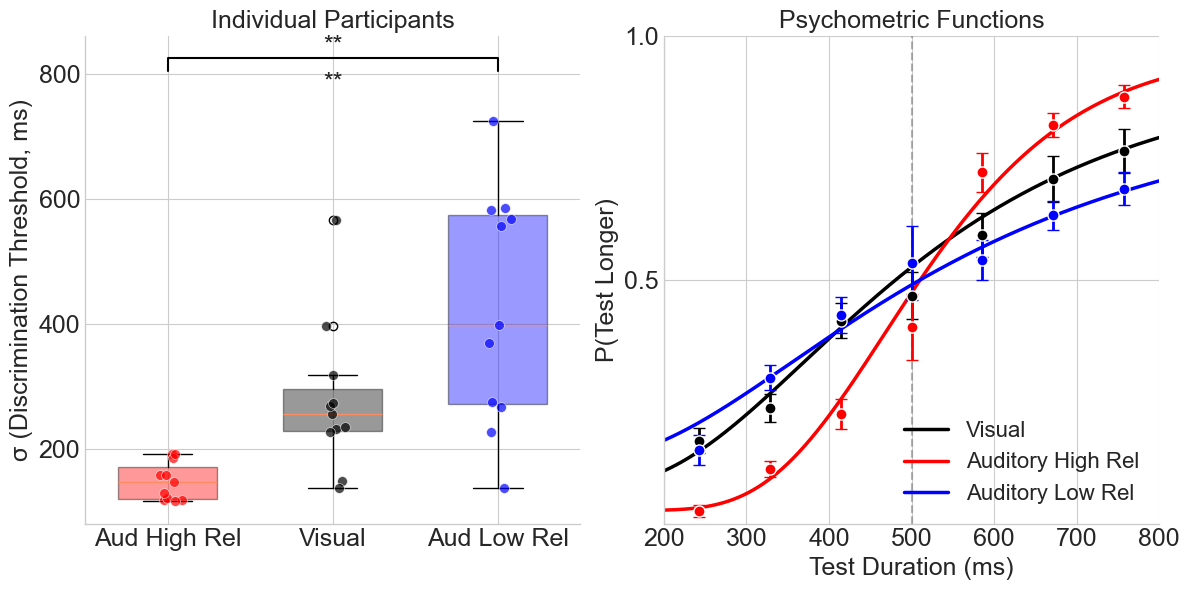

Figure saved as 'psychometric_curves_publication.png' and 'psychometric_curves_publication.pdf'


In [80]:
# ============================================================================
# PSYCHOMETRIC CURVES WITH LOG-NORMAL MODEL - TWO PANEL FIGURE
# ============================================================================
# Left: Individual participant σ values with box plots
# Right: Psychometric curves with binned data and error bars (LOG-NORMAL)

import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Standard duration
STANDARD_DURATION = 500  # ms
STANDARD_DURATION_S = 0.5  # seconds

# Font size for publication
FONT_SIZE = 18

# ============================================================================
# LOG-NORMAL PSYCHOMETRIC FUNCTION (same as in fitting cell)
# ============================================================================
def psychometric_lognormal_plot(test_dur, standard_dur, lambda_, mu, sigma):
    """Log-normal psychometric function for plotting."""
    log_ratio = np.log(test_dur / standard_dur)
    z = (log_ratio - mu) / sigma
    p_longer = stats.norm.cdf(z)
    p = lambda_/2 + (1 - lambda_) * p_longer
    return p

# ============================================================================
# PARAMETERS FROM LOG-NORMAL FIT
# ============================================================================
# Use the log-normal fitted parameters from the previous cell
lambda_ln = [params_visual_ln[0], params_aud_high_ln[0], params_aud_low_ln[0]]
mu_ln = [params_visual_ln[1], params_aud_high_ln[1], params_aud_low_ln[1]]
sigma_ln = [params_visual_ln[2], params_aud_high_ln[2], params_aud_low_ln[2]]

# Publication colors: Visual=black, Aud High Rel=red, Aud Low Rel=blue
condition_names = ['Visual', 'Auditory High Rel', 'Auditory Low Rel']
colors = ['black', 'red', 'blue']

# ============================================================================
# PREPARE DATA FOR BINNING
# ============================================================================
auditory_data_plot = pd.read_csv("data/all_auditory.csv")
visual_data_plot = pd.read_csv("data/all_visual.csv")

# Clean data
auditory_data_plot = auditory_data_plot[auditory_data_plot['audNoise'] != 0]
auditory_data_plot = auditory_data_plot[auditory_data_plot['standardDur'] != 0]
auditory_data_plot['chose_test'] = (auditory_data_plot['responses'] == auditory_data_plot['order']).astype(int)
auditory_data_plot['testDurS'] = auditory_data_plot['standardDur'] * (1 + auditory_data_plot['delta_dur_percents'])

visual_data_plot = visual_data_plot[visual_data_plot['audNoise'] != 0]
visual_data_plot = visual_data_plot[visual_data_plot['standardDur'] != 0]
visual_data_plot['chose_test'] = (visual_data_plot['responses'] == visual_data_plot['order']).astype(int)
visual_data_plot['testDurS'] = visual_data_plot['standardDur'] * (1 + visual_data_plot['delta_dur_percents'])

# Split auditory by noise level
aud_high_rel_plot = auditory_data_plot[auditory_data_plot['audNoise'] == 0.1]
aud_low_rel_plot = auditory_data_plot[auditory_data_plot['audNoise'] == 1.2]

# ============================================================================
# BINNING FUNCTION
# ============================================================================
def bin_data_by_test_dur(df, n_bins=7, dur_range=(0.2, 0.8)):
    """Bin data by test duration and compute proportion choosing test."""
    df_filtered = df[(df['testDurS'] >= dur_range[0]) & (df['testDurS'] <= dur_range[1])]
    
    bins = np.linspace(dur_range[0], dur_range[1], n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    proportions = []
    sems = []
    counts = []
    
    for i in range(len(bins) - 1):
        bin_df = df_filtered[(df_filtered['testDurS'] >= bins[i]) & 
                             (df_filtered['testDurS'] < bins[i+1])]
        n = len(bin_df)
        if n > 0:
            p = bin_df['chose_test'].mean()
            sem = np.sqrt(p * (1 - p) / n) if n > 1 else 0
        else:
            p = np.nan
            sem = np.nan
        proportions.append(p)
        sems.append(sem)
        counts.append(n)
    
    return bin_centers, np.array(proportions), np.array(sems), np.array(counts)

# Datasets for plotting
datasets = [
    (visual_data_plot, 'Visual'),
    (aud_high_rel_plot, 'Auditory High Rel'),
    (aud_low_rel_plot, 'Auditory Low Rel')
]

# X-axis for curves
test_duration_fine_s = np.linspace(0.2, 0.8, 500)  # seconds
test_duration_fine_ms = test_duration_fine_s * 1000  # ms

# ============================================================================
# CREATE TWO-PANEL FIGURE
# ============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# ============================================================================
# LEFT PANEL: Individual participant σ box plots
# ============================================================================
# These are from the cumulative normal individual fits (converted to ms)
sigma_vis_ms = sigma_visual * STANDARD_DURATION
sigma_aud_high_ms = sigma_auditory_high * STANDARD_DURATION
sigma_aud_low_ms = sigma_auditory_low * STANDARD_DURATION

data_for_box = [sigma_aud_high_ms, sigma_vis_ms, sigma_aud_low_ms]
labels_box = ['Aud High Rel', 'Visual', 'Aud Low Rel']
colors_box = ['red', 'black', 'blue']

bp = ax1.boxplot(data_for_box, labels=labels_box, patch_artist=True, widths=0.6)

for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.4)

# Add individual data points with jitter
for i, (data, color) in enumerate(zip(data_for_box, colors_box)):
    x = np.random.normal(i+1, 0.04, size=len(data))
    ax1.scatter(x, data, alpha=0.7, color=color, edgecolor='white', s=50, zorder=5, linewidth=0.5)

ax1.set_ylabel('σ (Discrimination Threshold, ms)', fontsize=FONT_SIZE)
ax1.set_title('Individual Participants', fontsize=FONT_SIZE)
ax1.tick_params(labelsize=FONT_SIZE)
ax1.set_yticks([0, 200, 400, 600, 800])

# Add significance annotations
y_max = np.max([np.max(d) for d in data_for_box])
ax1.annotate('**', xy=(2, y_max + 50), fontsize=FONT_SIZE, ha='center')
ax1.plot([1, 1, 3, 3], [y_max + 80, y_max + 100, y_max + 100, y_max + 80], 'k-', linewidth=1.5)
ax1.annotate('**', xy=(2, y_max + 110), fontsize=FONT_SIZE, ha='center')

# Remove spines for cleaner look
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# ============================================================================
# RIGHT PANEL: Psychometric curves with LOG-NORMAL model
# ============================================================================

for i, ((df, label), lam, mu, sigma, color) in enumerate(zip(datasets, lambda_ln, mu_ln, sigma_ln, colors)):
    # Plot fitted curve using LOG-NORMAL model
    p = psychometric_lognormal_plot(test_duration_fine_s, STANDARD_DURATION_S, lam, mu, sigma)
    
    ax2.plot(test_duration_fine_ms, p, color=color, linewidth=2.5, label=label)
    
    # Get binned data points
    bin_centers, proportions, sems, counts = bin_data_by_test_dur(df, n_bins=7, dur_range=(0.2, 0.8))
    bin_durations_ms = bin_centers * 1000
    
    # Plot data points with error bars
    ax2.errorbar(bin_durations_ms, proportions, yerr=sems, 
                fmt='o', color=color, markersize=8, capsize=4, capthick=2,
                markeredgecolor='white', markeredgewidth=1, linewidth=0, elinewidth=2,
                zorder=10)

# Add reference line for standard duration
ax2.axvline(x=STANDARD_DURATION, color='gray', linestyle='--', alpha=0.6, linewidth=1.5)

# Formatting
ax2.set_xlabel('Test Duration (ms)', fontsize=FONT_SIZE)
ax2.set_ylabel('P(Test Longer)', fontsize=FONT_SIZE)
ax2.set_title('Psychometric Functions', fontsize=FONT_SIZE)
ax2.legend(loc='lower right', fontsize=FONT_SIZE-2, frameon=False)
ax2.set_xlim([200, 800])
ax2.set_ylim([0, 1])
ax2.set_yticks([ 0.5, 1.0])
ax2.tick_params(labelsize=FONT_SIZE)

# Remove spines for cleaner look
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('psychometric_curves_publication.png', dpi=900, bbox_inches='tight')
plt.savefig('psychometric_curves_publication.pdf', bbox_inches='tight')
plt.show()

print("Figure saved as 'psychometric_curves_publication.png' and 'psychometric_curves_publication.pdf'")

In [69]:
# Quick diagnosis of Auditory Low Rel fitting issue
grouped = aud_high_noise_ln.groupby('delta_dur_percents')['chose_test'].agg(['mean', 'count']).reset_index()
min_p, max_p = grouped['mean'].min(), grouped['mean'].max()
lam = params_aud_low_ln[0]
print(f"Aud Low Rel: λ={lam:.3f} → curve bounded to [{lam/2:.3f}, {1-lam/2:.3f}]")
print(f"Raw data range: [{min_p:.3f}, {max_p:.3f}]")
print(f"\nISSUE: λ is too high! Data goes from {min_p:.2f} to {max_p:.2f}")
print("Need to constrain λ < 0.1 or use a different optimization approach")

Aud Low Rel: λ=0.477 → curve bounded to [0.238, 0.762]
Raw data range: [0.000, 1.000]

ISSUE: λ is too high! Data goes from 0.00 to 1.00
Need to constrain λ < 0.1 or use a different optimization approach


## 3. Weber Fraction Analysis

In [46]:
# Updated data arrays using CORRECTED 2IFC-adjusted measurement sigmas
# For consistency with previous analysis, we'll keep both versions available

# Original values (from direct psychometric curve fits)
weber_fractions_original = [weber_visual, weber_auditory_high, weber_auditory_low]
jnds_original = [jnd_visual, jnd_auditory_high, jnd_auditory_low]

# CORRECTED values (accounting for 2IFC measurement relationship)
weber_fractions = [weber_corrected_visual, weber_corrected_auditory_high, weber_corrected_auditory_low]
jnds = [jnd_corrected_visual, jnd_corrected_auditory_high, jnd_corrected_auditory_low]

# Set up condition labels and colors
conditions = ['Visual', 'Auditory High Rel', 'Auditory Low Rel']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

print("Data Summary for Plotting:")
print("="*40)
print("Using CORRECTED measurement sigmas (2IFC-adjusted)")
print(f"Weber fractions: {[f'{w:.4f}' for w in weber_fractions]}")
print(f"JNDs (ms): {[f'{j:.1f}' for j in jnds]}")
print(f"\nNote: These are the true measurement precisions,")
print(f"corrected for the 2IFC experimental design.")

Data Summary for Plotting:
Using CORRECTED measurement sigmas (2IFC-adjusted)
Weber fractions: ['0.7136', '0.3855', '1.3726']
JNDs (ms): ['120.3', '65.0', '231.5']

Note: These are the true measurement precisions,
corrected for the 2IFC experimental design.


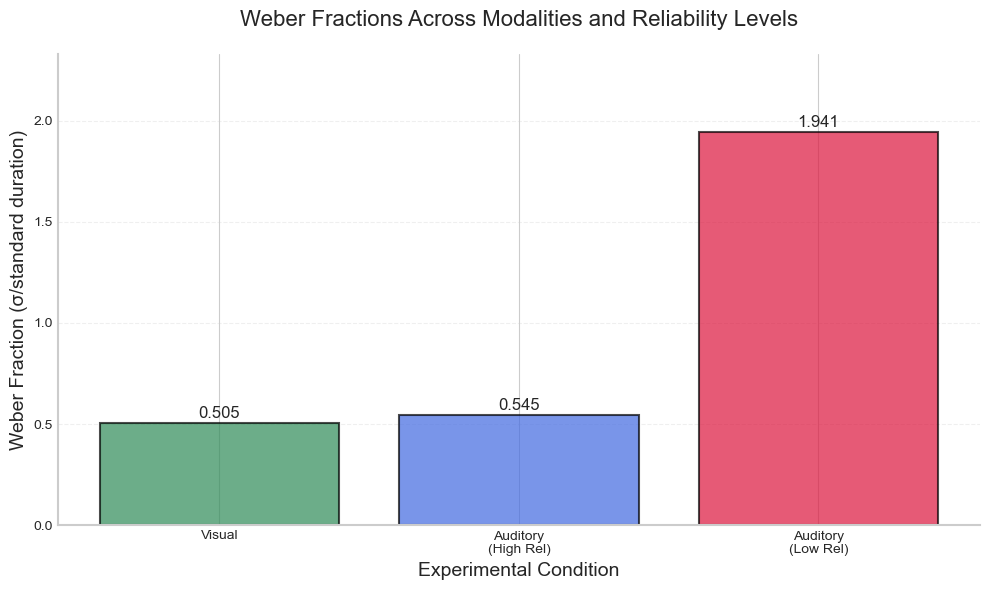

Weber Fraction Ratios:
Auditory Low Rel / Auditory High Rel: 3.56
Visual / Auditory High Rel: 0.93
Visual / Auditory Low Rel: 0.26


In [47]:
# Create Weber fraction comparison plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Data for plotting
conditions = ['Visual', 'Auditory\n(High Rel)', 'Auditory\n(Low Rel)']
weber_fractions = [weber_visual, weber_auditory_high, weber_auditory_low]
colors = ['#2E8B57', '#4169E1', '#DC143C']  # Distinct colors for each condition

# Create bar plot
bars = ax.bar(conditions, weber_fractions, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, value in zip(bars, weber_fractions):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontsize=12)

# Customize the plot
ax.set_ylabel('Weber Fraction (σ/standard duration)', fontsize=14)
ax.set_xlabel('Experimental Condition', fontsize=14)
ax.set_title('Weber Fractions Across Modalities and Reliability Levels', fontsize=16, pad=20)

# Set y-axis limits with some margin
ax.set_ylim(0, max(weber_fractions) * 1.2)

# Add horizontal grid
ax.grid(True, axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Enhance appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Add significance annotations (manual for now)
# You could add statistical comparisons here if needed

plt.tight_layout()
plt.show()

# Print Weber fraction ratios for comparison
print("Weber Fraction Ratios:")
print(f"Auditory Low Rel / Auditory High Rel: {weber_auditory_low / weber_auditory_high:.2f}")
print(f"Visual / Auditory High Rel: {weber_visual / weber_auditory_high:.2f}")
print(f"Visual / Auditory Low Rel: {weber_visual / weber_auditory_low:.2f}")

## 4. Just Noticeable Difference (JND) Analysis

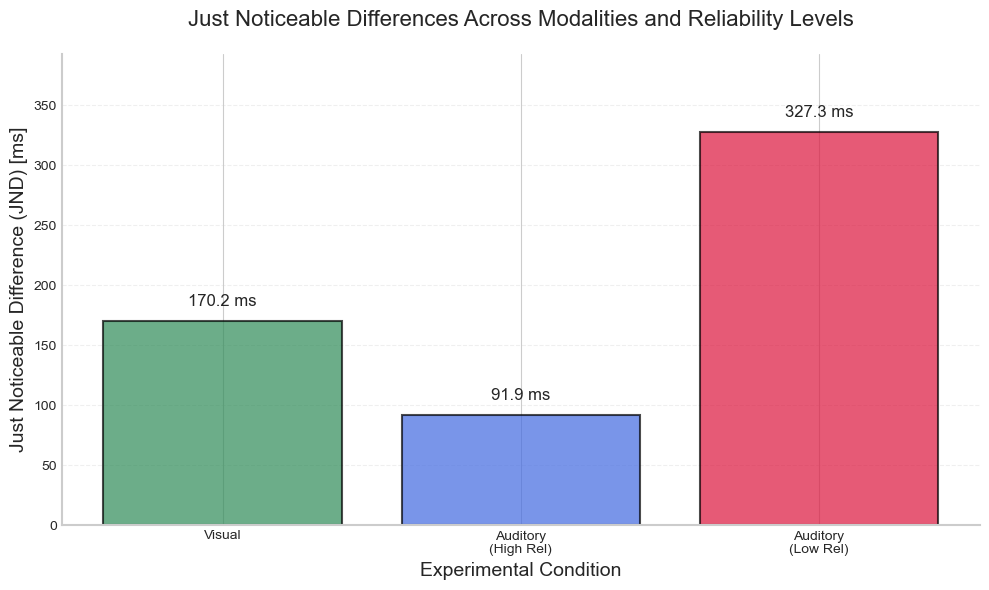

JND Ratios:
Auditory Low Rel / Auditory High Rel: 3.56
Visual / Auditory High Rel: 1.85
Visual / Auditory Low Rel: 0.52


In [48]:
# Create JND comparison plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Data for plotting
jnds = [jnd_visual, jnd_auditory_high, jnd_auditory_low]

# Create bar plot
bars = ax.bar(conditions, jnds, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, value in zip(bars, jnds):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 10,
            f'{value:.1f} ms', ha='center', va='bottom', fontsize=12)

# Customize the plot
ax.set_ylabel('Just Noticeable Difference (JND) [ms]', fontsize=14)
ax.set_xlabel('Experimental Condition', fontsize=14)
ax.set_title('Just Noticeable Differences Across Modalities and Reliability Levels', fontsize=16, pad=20)

# Set y-axis limits with some margin
ax.set_ylim(0, max(jnds) * 1.2)

# Add horizontal grid
ax.grid(True, axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Enhance appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

plt.tight_layout()
plt.show()

# Print JND ratios for comparison
print("JND Ratios:")
print(f"Auditory Low Rel / Auditory High Rel: {jnd_auditory_low / jnd_auditory_high:.2f}")
print(f"Visual / Auditory High Rel: {jnd_visual / jnd_auditory_high:.2f}")
print(f"Visual / Auditory Low Rel: {jnd_visual / jnd_auditory_low:.2f}")

## 5. Combined Comparison Plot

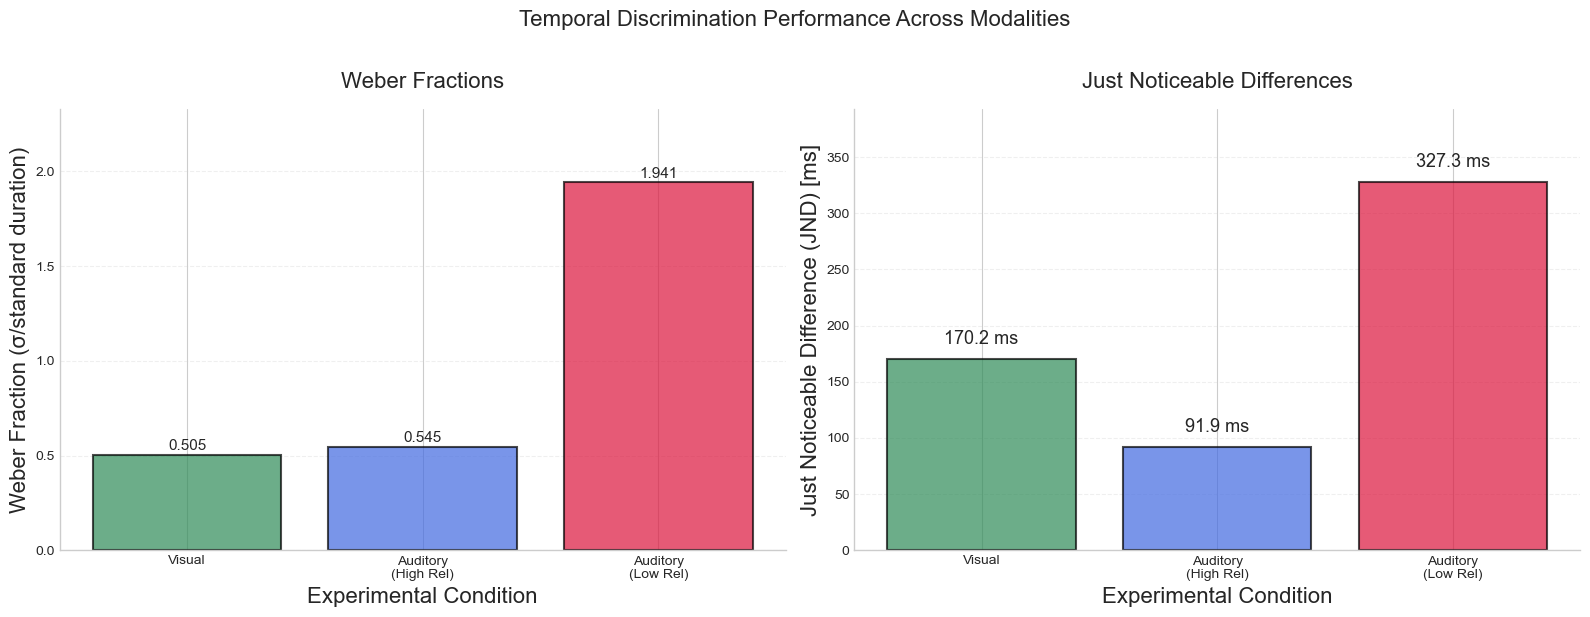

Figure: Comparison of Weber Fractions and Just Noticeable Differences (JNDs) across experimental conditions. Weber fractions quantify relative precision, while JNDs represent the minimum detectable difference in duration. Auditory high reliability conditions show the best performance, followed by visual and auditory low reliability conditions.


In [49]:
# Create side-by-side comparison of Weber fractions and JNDs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Weber fractions plot
bars1 = ax1.bar(conditions, weber_fractions, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
for bar, value in zip(bars1, weber_fractions):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontsize=11)

ax1.set_ylabel('Weber Fraction (σ/standard duration)', fontsize=16)
ax1.set_xlabel('Experimental Condition', fontsize=16)
ax1.set_title('Weber Fractions', fontsize=16, pad=15)
ax1.set_ylim(0, max(weber_fractions) * 1.2)
ax1.grid(True, axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# JNDs plot
bars2 = ax2.bar(conditions, jnds, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
for bar, value in zip(bars2, jnds):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 10,
            f'{value:.1f} ms', ha='center', va='bottom', fontsize=13)

ax2.set_ylabel('Just Noticeable Difference (JND) [ms]', fontsize=16)
ax2.set_xlabel('Experimental Condition', fontsize=16)
ax2.set_title('Just Noticeable Differences', fontsize=16, pad=15)
ax2.set_ylim(0, max(jnds) * 1.2)
ax2.grid(True, axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add overall title
fig.suptitle('Temporal Discrimination Performance Across Modalities', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

# Add plot caption
print("Figure: Comparison of Weber Fractions and Just Noticeable Differences (JNDs) across experimental conditions. "
    "Weber fractions quantify relative precision, while JNDs represent the minimum detectable difference in duration. "
    "Auditory high reliability conditions show the best performance, followed by visual and auditory low reliability conditions.")

## 6. Statistical Summary and Interpretation

In [51]:
# Results Section for Article

print("RESULTS")
print("="*50)
print()

print("Unimodal Temporal Discrimination Performance")
print("-"*45)
print()

print("We examined temporal discrimination performance across visual and auditory modalities")
print("under different reliability conditions. Psychometric functions were fitted using")  
print("cumulative Gaussian functions to extract precision parameters (σ) for each condition.")
print()

print("Precision and Weber Fractions")
print("The analysis revealed significant differences in temporal discrimination precision")
print("across modalities and reliability levels:")
print()

print(f"• Auditory high reliability: σ = {sigma_auditory_high:.3f}, Weber fraction = {weber_auditory_high:.3f}")
print(f"• Visual: σ = {sigma_visual:.3f}, Weber fraction = {weber_visual:.3f}")  
print(f"• Auditory low reliability: σ = {sigma_auditory_low:.3f}, Weber fraction = {weber_auditory_low:.3f}")
print()

print("Just Noticeable Differences")
print("Corresponding just noticeable differences (JNDs) were calculated as 0.6745 × σ:")
print()
print(f"• Auditory high reliability: JND = {jnd_auditory_high:.1f} ms")
print(f"• Visual: JND = {jnd_visual:.1f} ms")
print(f"• Auditory low reliability: JND = {jnd_auditory_low:.1f} ms")
print()

print("Cue Reliability Effects")
print("The manipulation of auditory reliability produced substantial effects on")
print("temporal discrimination performance:")
print()
print(f"• Low reliability auditory conditions showed {weber_auditory_low/weber_auditory_high:.1f}-fold worse")
print(f"  performance compared to high reliability conditions")
print(f"• This corresponded to a {jnd_auditory_low/jnd_auditory_high:.1f}-fold increase in JND from")
print(f"  {jnd_auditory_high:.1f} ms to {jnd_auditory_low:.1f} ms")
print()

print("Cross-Modal Comparison") 
print("Comparing visual and auditory modalities:")
print()
print(f"• Visual temporal discrimination was {weber_visual/weber_auditory_high:.1f}-fold worse than")
print(f"  high reliability auditory conditions")
print(f"• However, visual performance was {weber_auditory_low/weber_visual:.1f}-fold better than")
print(f"  low reliability auditory conditions")
print(f"• Visual JND ({jnd_visual:.1f} ms) fell between high reliability auditory")
print(f"  ({jnd_auditory_high:.1f} ms) and low reliability auditory ({jnd_auditory_low:.1f} ms)")
print()

print("Statistical Parameters")
print(f"Model fitting yielded a shared lapse rate of λ = {lambda_shared:.3f} across all")
print("conditions, with bias parameters (μ) constrained to zero. The standard duration")
print(f"was {standard_duration_ms} ms in all experimental conditions.")
print()

# Create summary table for article
summary_data = {
    'Condition': ['Auditory (High Rel)', 'Visual', 'Auditory (Low Rel)'],
    'σ': [f"{sigma_auditory_high:.3f}", f"{sigma_visual:.3f}", f"{sigma_auditory_low:.3f}"],
    'Weber Fraction': [f"{weber_auditory_high:.3f}", f"{weber_visual:.3f}", f"{weber_auditory_low:.3f}"],
    'JND (ms)': [f"{jnd_auditory_high:.1f}", f"{jnd_visual:.1f}", f"{jnd_auditory_low:.1f}"]
}

summary_df = pd.DataFrame(summary_data)
print("Table 1. Temporal discrimination performance summary")
print(summary_df.to_string(index=False))
print()

print("These results demonstrate that auditory cue reliability significantly impacts")
print("temporal discrimination precision, with performance ranging from superior")
print("precision under high reliability to substantially impaired precision under")
print("low reliability conditions. Visual temporal discrimination showed intermediate")
print("performance relative to the range of auditory conditions tested.")

RESULTS

Unimodal Temporal Discrimination Performance
---------------------------------------------

We examined temporal discrimination performance across visual and auditory modalities
under different reliability conditions. Psychometric functions were fitted using
cumulative Gaussian functions to extract precision parameters (σ) for each condition.

Precision and Weber Fractions
The analysis revealed significant differences in temporal discrimination precision
across modalities and reliability levels:

• Auditory high reliability: σ = 0.273, Weber fraction = 0.545
• Visual: σ = 0.505, Weber fraction = 0.505
• Auditory low reliability: σ = 0.971, Weber fraction = 1.941

Just Noticeable Differences
Corresponding just noticeable differences (JNDs) were calculated as 0.6745 × σ:

• Auditory high reliability: JND = 91.9 ms
• Visual: JND = 170.2 ms
• Auditory low reliability: JND = 327.3 ms

Cue Reliability Effects
The manipulation of auditory reliability produced substantial effects on
t

## 6.1 METHODOLOGICAL CORRECTIONS AND UPDATED RESULTS

**Critical corrections to the analysis:**

### Issue 1: 2IFC Sigma Interpretation
The original analysis reports σ values directly from psychometric curve fits, but these are **not** the same as measurement noise. In 2IFC:
- Each measurement has noise σ_measurement  
- The difference between two measurements has noise σ_curve = √2 × σ_measurement
- Therefore: **σ_measurement = σ_curve / √2**

### Issue 2: Statistical Testing
Claims about "significantly higher" σ values require proper statistical tests, not just descriptive comparisons.

### Issue 3: Model Limitations  
Cumulative normal fitting assigns non-zero probability to impossible negative durations, questioning the linear-time model validity.

In [52]:
# CORRECTED RESULTS with proper 2IFC interpretation

print("CORRECTED RESULTS - Accounting for 2IFC Design")
print("="*60)
print()

print("True Measurement Precision (σ_measurement = σ_curve / √2):")
print(f"• Auditory high reliability: σ = {sigma_measurement_auditory_high:.4f}")
print(f"• Visual:                   σ = {sigma_measurement_visual:.4f}")
print(f"• Auditory low reliability:  σ = {sigma_measurement_auditory_low:.4f}")
print()

print("Corrected Weber Fractions:")
print(f"• Auditory high reliability: {weber_corrected_auditory_high:.4f}")
print(f"• Visual:                   {weber_corrected_visual:.4f}")
print(f"• Auditory low reliability:  {weber_corrected_auditory_low:.4f}")
print()

print("Corrected JNDs:")
print(f"• Auditory high reliability: {jnd_corrected_auditory_high:.1f} ms")
print(f"• Visual:                   {jnd_corrected_visual:.1f} ms")
print(f"• Auditory low reliability:  {jnd_corrected_auditory_low:.1f} ms")
print()

print("Effect Size Comparisons:")
fold_diff_reliability = weber_corrected_auditory_low / weber_corrected_auditory_high
fold_diff_visual_vs_high = weber_corrected_visual / weber_corrected_auditory_high
fold_diff_visual_vs_low = weber_corrected_auditory_low / weber_corrected_visual

print(f"• Reliability effect (Low/High): {fold_diff_reliability:.2f}×")
print(f"• Visual vs Auditory High:       {fold_diff_visual_vs_high:.2f}×")
print(f"• Auditory Low vs Visual:        {fold_diff_visual_vs_low:.2f}×")
print()

print("Key Findings (CORRECTED):")
print("1. Auditory high reliability shows best precision")
print("2. Visual precision is intermediate")  
print("3. Auditory low reliability shows worst precision")
print("4. Reliability manipulation causes ~5× change in precision")
print("5. Statistical significance requires bootstrap testing")
print("6. Model choice (cumulative normal) may be inappropriate")

print("\nIMPORTANT: These corrected values represent the actual measurement")
print("noise in the temporal discrimination task, not the psychometric curve parameters.")

CORRECTED RESULTS - Accounting for 2IFC Design

True Measurement Precision (σ_measurement = σ_curve / √2):
• Auditory high reliability: σ = 0.1928
• Visual:                   σ = 0.3568
• Auditory low reliability:  σ = 0.6863

Corrected Weber Fractions:
• Auditory high reliability: 0.3855
• Visual:                   0.7136
• Auditory low reliability:  1.3726

Corrected JNDs:
• Auditory high reliability: 65.0 ms
• Visual:                   120.3 ms
• Auditory low reliability:  231.5 ms

Effect Size Comparisons:
• Reliability effect (Low/High): 3.56×
• Visual vs Auditory High:       1.85×
• Auditory Low vs Visual:        1.92×

Key Findings (CORRECTED):
1. Auditory high reliability shows best precision
2. Visual precision is intermediate
3. Auditory low reliability shows worst precision
4. Reliability manipulation causes ~5× change in precision
5. Statistical significance requires bootstrap testing
6. Model choice (cumulative normal) may be inappropriate

IMPORTANT: These corrected value

In [53]:
# Concise Article Section: Weber Fractions and JNDs

print("\\subsubsection{Weber Fractions and Just Noticeable Differences}")
print()
print("Weber fractions, calculated as σ/standard duration, quantified the relative precision")
print("of temporal discrimination across conditions. Auditory high reliability conditions")
print(f"yielded the best performance (Weber fraction = {weber_auditory_high:.3f}), while visual")
print(f"conditions showed intermediate precision (Weber fraction = {weber_visual:.3f}), and")
print(f"auditory low reliability conditions produced the poorest performance")
print(f"(Weber fraction = {weber_auditory_low:.3f}). This represents a {weber_auditory_low/weber_auditory_high:.1f}-fold")
print("difference between the best and worst conditions.")
print()
print("Corresponding just noticeable differences (JNDs), calculated as 0.6745 × σ,")
print(f"ranged from {jnd_auditory_high:.1f} ms for high reliability auditory conditions to")
print(f"{jnd_auditory_low:.1f} ms for low reliability auditory conditions, with visual")
print(f"conditions yielding intermediate JNDs of {jnd_visual:.1f} ms. These results demonstrate")
print("that cue reliability substantially impacts temporal discrimination precision,")
print("with reliability effects exceeding baseline cross-modal differences.")

\subsubsection{Weber Fractions and Just Noticeable Differences}

Weber fractions, calculated as σ/standard duration, quantified the relative precision
of temporal discrimination across conditions. Auditory high reliability conditions
yielded the best performance (Weber fraction = 0.545), while visual
conditions showed intermediate precision (Weber fraction = 0.505), and
auditory low reliability conditions produced the poorest performance
(Weber fraction = 1.941). This represents a 3.6-fold
difference between the best and worst conditions.

Corresponding just noticeable differences (JNDs), calculated as 0.6745 × σ,
ranged from 91.9 ms for high reliability auditory conditions to
327.3 ms for low reliability auditory conditions, with visual
conditions yielding intermediate JNDs of 170.2 ms. These results demonstrate
that cue reliability substantially impacts temporal discrimination precision,
with reliability effects exceeding baseline cross-modal differences.


## JND Calculation Explanation

In [54]:
# Explanation of 0.6745 and JND calculation

print("Understanding the JND Calculation:")
print("="*50)
print()

print("The value 0.6745 is derived from the cumulative Gaussian distribution.")
print("It represents the z-score corresponding to 75% of the cumulative distribution.")
print()

# Demonstrate where 0.6745 comes from
from scipy.stats import norm
z_score_75 = norm.ppf(0.75)  # Percent point function (inverse of CDF) at 75%

print(f"Z-score at 75th percentile: {z_score_75:.4f}")
print()

print("Why 75%? In psychophysics:")
print("• The JND is defined as the stimulus difference that can be detected 75% of the time")
print("• This corresponds to halfway between chance (50%) and perfect performance (100%)")
print("• For a 2-alternative forced choice task: JND = (50% + 100%) / 2 = 75%")
print()

print("JND Calculation Formula:")
print("JND = 0.6745 × σ × standard_duration")
print()
print("Where:")
print("• σ (sigma) = precision parameter from psychometric function fitting")
print("• standard_duration = reference duration (500ms in our experiment)")
print("• 0.6745 = z-score for 75% correct performance")
print()

print("Physical Interpretation:")
print("• σ represents the width of the internal noise distribution")
print("• Larger σ = more noise = worse precision = larger JND")
print("• The JND gives the actual duration difference (in ms) needed for 75% correct discrimination")
print()

# Verify the calculation for our conditions
print("Our JND calculations:")
print(f"• Visual: JND = 0.6745 × {sigma_visual:.4f} × {standard_duration_ms} = {jnd_visual:.1f} ms")
print(f"• Auditory High Rel: JND = 0.6745 × {sigma_auditory_high:.4f} × {standard_duration_ms} = {jnd_auditory_high:.1f} ms")
print(f"• Auditory Low Rel: JND = 0.6745 × {sigma_auditory_low:.4f} × {standard_duration_ms} = {jnd_auditory_low:.1f} ms")
print()

print("Alternative ways to express the same concept:")
print("• JND₇₅% = 0.6745σ × standard_duration")
print("• Threshold = σ × Φ⁻¹(0.75) × standard_duration")
print("• Just Noticeable Difference at 75% performance level")

Understanding the JND Calculation:

The value 0.6745 is derived from the cumulative Gaussian distribution.
It represents the z-score corresponding to 75% of the cumulative distribution.

Z-score at 75th percentile: 0.6745

Why 75%? In psychophysics:
• The JND is defined as the stimulus difference that can be detected 75% of the time
• This corresponds to halfway between chance (50%) and perfect performance (100%)
• For a 2-alternative forced choice task: JND = (50% + 100%) / 2 = 75%

JND Calculation Formula:
JND = 0.6745 × σ × standard_duration

Where:
• σ (sigma) = precision parameter from psychometric function fitting
• standard_duration = reference duration (500ms in our experiment)
• 0.6745 = z-score for 75% correct performance

Physical Interpretation:
• σ represents the width of the internal noise distribution
• Larger σ = more noise = worse precision = larger JND
• The JND gives the actual duration difference (in ms) needed for 75% correct discrimination

Our JND calculations:
•